In [1]:
#%% Import Moduels

## System Tools
import os
import sys
import numpy as np
from collections import OrderedDict
import itertools
## I/O Tools
import pickle as pickle
## Data Process Tools
import pandas as pd
# import modin.pandas as pd
import datetime
## Graphs
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as figpdf
# import Graphics as MyGR
## Statistical Tools
from scipy.stats import t as TDist
import statsmodels.formula.api as sm
from statsmodels.tsa.api import VAR
from scipy.stats import mstats
import statsmodels.api as SMAPI
from statsmodels.tsa.tsatools import detrend as DeTrend
from statsmodels.tsa.filters.hp_filter import hpfilter as HPfilter
from statsmodels.tsa.filters.bk_filter import bkfilter as BKfilter
## Database API
# from fredapi import Fred
# fred = Fred(api_key='86cde3dec5dda5ffca44b58f01838b1e')
## Numerical API
from scipy.interpolate import interp1d
## Regular Expression API
import re
# import ray

idx = pd.IndexSlice
# End of Section: Import Moduels
###############################################################################

#%% Setup Working Directory
## Windows System Path
FolderList = [xx+"\\Dropbox\\Research Projects\\02_EquityMarkets_MonetaryPolicy\\Data\\Micro_data\\codes\\" \
              for xx in ["D:\\", "E:\\","B:\\","/mnt/b/"]]
for Folder in FolderList:
    if os.path.exists(Folder):
        os.chdir(Folder)     

## Output Folder
OutputFolder = 'TableGraph/SumStat/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
# End of Section: Setup Working Directory
###############################################################################


In [2]:
sys.path.append("../../../../../Code/PythonLib/")

import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR

In [3]:
# plt.rcParams.update({'font.family':'sans-serif'})
# plt.rcParams.update({'font.sans-serif':'Helvetica'})

In [4]:
import stata_setup
stata_setup.config("D:/Stata17/","mp")
from pystata import stata
stata.run('set processors 8')


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Xing Guo
               Bank of Canada

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.

Running c:\ado\plus\profile.do ...
command window is unrecognized
r(199);
    The maximum number of processors or cores being used 

# Load in the Compustat data set

In [5]:
DS = pickle.load(open("../../../../../Data/CompuStat/CleanedSample/TempData/Sample_CS_Q_Cleaned.p", "rb"))

In [6]:
DS['IpoYear'] = DS['ipodate'].dt.year

1. Investment rate: mean and standard deviation
2. Equity issuance flow: frequency of issuance, average size of issuance
3. Dividend payment: average size of dividend flow
4. Persistence and standard variation of cash flow and investment
5. Life-cycle difference in size and cash-flow rate
6. Price drop: average price drop

In [7]:
year1 = 1990
year2 = 2022

# Moments based on summary statistics

## Prepare the data

### Quarterly

In [8]:
DS['InvRate'] = DS['CapExp']/DS['Lag_Asset']*4*100
DS['EquIssRate'] = DS['EquityIssuance']/DS['Lag_Asset']*400
DS['Payout'] = DS['Dividend']+DS['StockRepurchase']
DS['PayoutRate'] = DS['Payout']/DS['Lag_Asset']*400
DS['OptCashFlowRate'] = DS['OptCashFlow']/DS['Lag_Asset']*4*100
DS['SalesRate'] = DS['Sales']/DS['Lag_Asset']*4*100

DS['LogInv'] = np.log(DS['CapExp'])

DS['Lag_Leverage_Gross'] = DS['Lag_Debt']/DS['Lag_Asset'] * 100
DS['Lag_Leverage_Net'] = DS['Lag_NetDebt']/DS['Lag_Asset'] * 100
DS['Leverage_Gross'] = DS['Debt']/DS['Asset'] * 100
DS['Leverage_Net'] = DS['NetDebt']/DS['Asset'] * 100


c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Annual 

In [9]:
VarList_KeyFlow = ['CapExp', 'EquityIssuance', 'Payout', 'OptCashFlow', 'Sales']
VarList_KeyStock = ['Asset', 'NetDebt', 'Debt']

In [10]:
FlowPanel_A = DS.groupby(['gvkey', 'CalendarQtr_Year'])[VarList_KeyFlow].mean()*4

In [11]:
Stock_A = DS.sort_values(['gvkey', 'CalendarQtr']).reset_index(drop=True) \
            .groupby(['gvkey', 'CalendarQtr_Year'])[['gvkey', 'CalendarQtr_Year']+VarList_KeyStock].tail(1) \
            .set_index(['gvkey', 'CalendarQtr_Year'])

In [12]:
FlowPanel_A = FlowPanel_A.join(Stock_A[VarList_KeyStock])
FlowPanel_A[['Lag_'+vv for vv in VarList_KeyStock]] = FlowPanel_A.groupby('gvkey')[VarList_KeyStock].shift()

In [ ]:
for vv in VarList_KeyFlow:
    FlowPanel_A[vv+'_Rate'] = FlowPanel_A[vv]/FlowPanel_A['Lag_Asset']*100

FlowPanel_A['Growth_Rate'] = np.log(FlowPanel_A['Asset']/FlowPanel_A['Lag_Asset'])*100

FlowPanel_A['Lag_Leverage_Gross'] = FlowPanel_A['Lag_Debt']/FlowPanel_A['Lag_Asset'] * 100
FlowPanel_A['Lag_Leverage_Net'] = FlowPanel_A['Lag_NetDebt']/FlowPanel_A['Lag_Asset'] * 100
FlowPanel_A['Leverage_Gross'] = FlowPanel_A['Debt']/FlowPanel_A['Asset'] * 100
FlowPanel_A['Leverage_Net'] = FlowPanel_A['NetDebt']/FlowPanel_A['Asset'] * 100
FlowPanel_A['LogCapExp'] = np.log(FlowPanel_A['CapExp']) * 100

c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Average Flows

### Quarterly

<Axes: xlabel='CalendarQtr'>

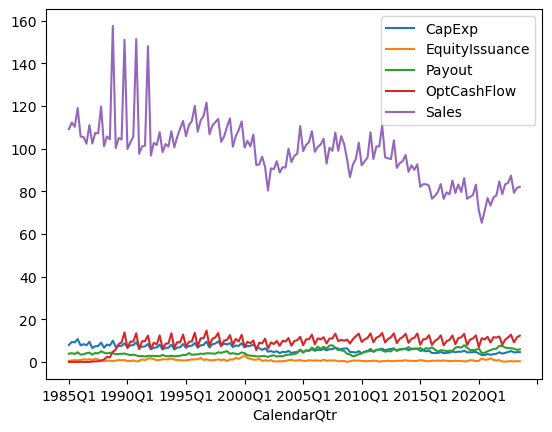

In [14]:
TempGroup = DS.groupby('CalendarQtr')
WAvgFlowTS = TempGroup[VarList_KeyFlow].sum().div(TempGroup['Lag_Asset'].sum(), axis=0)*400
WAvgFlowTS.plot()

In [15]:
WAvgFlowTS['Year'] = WAvgFlowTS.index.map(lambda x: int(x[0:4]))
WAvgFlowTS['Quarter'] = WAvgFlowTS.index.map(lambda x: int(x[-1]))

In [16]:
SampleInd = (WAvgFlowTS['Year']>=year1) & (WAvgFlowTS['Year']<=year2)
WAvgFlowTS.loc[SampleInd, VarList_KeyFlow].mean()

CapExp             5.908568
EquityIssuance     0.762526
Payout             4.652232
OptCashFlow       10.226267
Sales             96.523536
dtype: float64

#### Conditional issuing

In [18]:
TempInd = DS['EquIssRate']>0
TempGroup = DS.loc[TempInd, :].groupby('CalendarQtr')
WAvgFlowTS = TempGroup[VarList_KeyFlow].sum().div(TempGroup['Lag_Asset'].sum(), axis=0)*400

In [19]:
WAvgFlowTS['Year'] = WAvgFlowTS.index.map(lambda x: int(x[0:4]))
WAvgFlowTS['Quarter'] = WAvgFlowTS.index.map(lambda x: int(x[-1]))
SampleInd = (WAvgFlowTS['Year']>=year1) & (WAvgFlowTS['Year']<=year2)
WAvgFlowTS.loc[SampleInd, VarList_KeyFlow].mean()

CapExp             7.075390
EquityIssuance    20.665195
Payout             3.767347
OptCashFlow        5.841384
Sales             91.340672
dtype: float64

### Annual

In [26]:
TempGroup = FlowPanel_A.groupby('CalendarQtr_Year')
WAggFlowTS_A = TempGroup[VarList_KeyFlow].sum().div(TempGroup['Lag_Asset'].sum(), axis=0)*100

<Axes: xlabel='CalendarQtr_Year'>

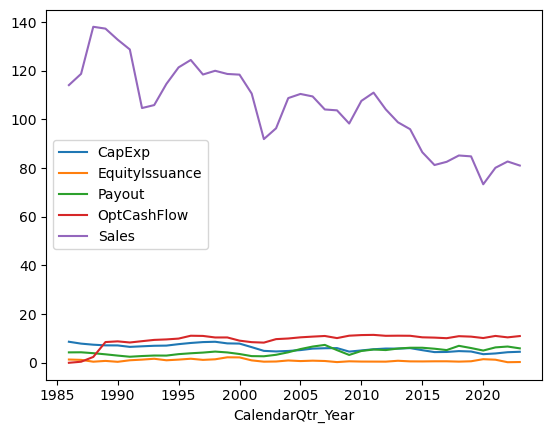

In [27]:
WAggFlowTS_A.plot()

In [28]:
WAggFlowTS_A.loc[year1:year2, :].mean()

CapExp              5.932894
EquityIssuance      0.933133
Payout              4.716568
OptCashFlow        10.240263
Sales             103.540724
dtype: float64

#### Conditional on issuing

In [29]:
TempInd = FlowPanel_A['EquityIssuance_Rate'] > 0
TempGroup = FlowPanel_A.loc[TempInd, :].groupby('CalendarQtr_Year')
WAggFlowTS_A = TempGroup[VarList_KeyFlow].sum().div(TempGroup['Lag_Asset'].sum(), axis=0)*100

WAggFlowTS_A.loc[year1:year2, :].mean()

CapExp             7.595822
EquityIssuance    11.019100
Payout             3.213316
OptCashFlow        5.639663
Sales             88.408346
dtype: float64

### Persistence

In [20]:
TempVarList = ['CapExp_Rate',	'EquityIssuance_Rate', 'Payout_Rate', 'OptCashFlow_Rate', 'Growth_Rate']

In [21]:
temp = FlowPanel_A.loc[idx[:, year1:2020], TempVarList]
temp = temp - temp.groupby('CalendarQtr_Year').mean()

In [22]:
temp = pd.concat([temp, temp.groupby('gvkey').shift(1).rename(columns={vv: vv+'_Lag' for vv in TempVarList})], axis=1, join='inner')

In [23]:
pd.Series([temp[[vv, vv+'_Lag']].corr().loc[vv, vv+'_Lag'] for vv in TempVarList], index=TempVarList)

CapExp_Rate            0.160820
EquityIssuance_Rate    0.029367
Payout_Rate            0.069875
OptCashFlow_Rate       0.269811
Growth_Rate            0.109640
dtype: float64

In [24]:
pd.Series([temp[[vv, vv+'_Lag']].corr().loc[vv, vv+'_Lag'] for vv in TempVarList], index=TempVarList)

CapExp_Rate            0.160820
EquityIssuance_Rate    0.029367
Payout_Rate            0.069875
OptCashFlow_Rate       0.269811
Growth_Rate            0.109640
dtype: float64

## Average Frequency

### Quarterly

In [25]:
VarList_KeyFlowRate = ['EquIssRate', 'PayoutRate', 'InvRate', 'OptCashFlowRate', 'SalesRate']

<Axes: xlabel='CalendarQtr'>

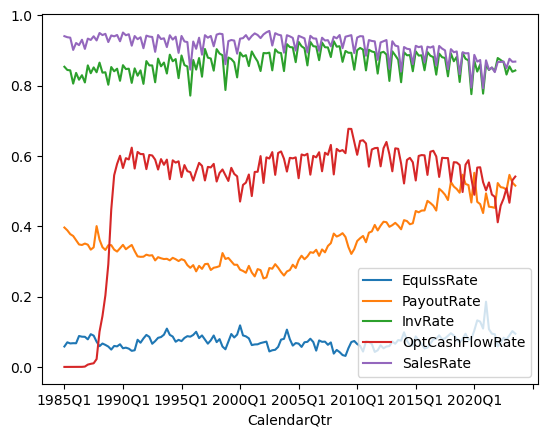

In [26]:
AvgFreqTS = (DS.set_index(['CalendarQtr', 'gvkey'])[VarList_KeyFlowRate]>1e-2*0).groupby('CalendarQtr').mean()
AvgFreqTS.plot()

In [27]:
AvgFreqTS['Year'] = AvgFreqTS.index.map(lambda x: int(x[0:4]))
AvgFreqTS['Quarter'] = AvgFreqTS.index.map(lambda x: int(x[-1]))

In [28]:
AvgFreqTS.loc[(AvgFreqTS['Year']>=year1) & (AvgFreqTS['Year']<=year2), VarList_KeyFlowRate].mean()

EquIssRate         0.074481
PayoutRate         0.362435
InvRate            0.870856
OptCashFlowRate    0.573861
SalesRate          0.913080
dtype: float64

### Annual

<Axes: xlabel='CalendarQtr_Year'>

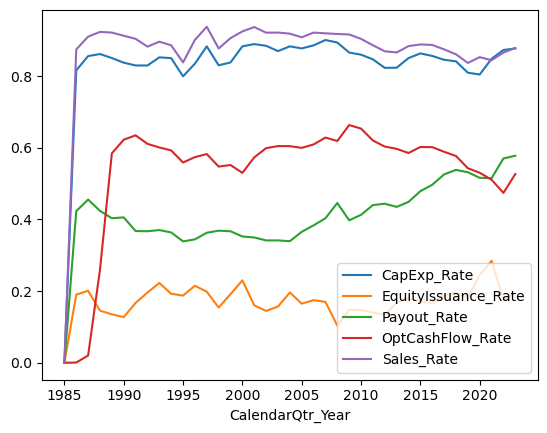

In [29]:
AvgFreqTS_A = (FlowPanel_A[[vv+'_Rate' for vv in VarList_KeyFlow]]>1e-2).groupby('CalendarQtr_Year').mean()
AvgFreqTS_A.plot()

In [30]:
AvgFreqTS_A.loc[year1:year2,:].mean()

CapExp_Rate            0.853713
EquityIssuance_Rate    0.178241
Payout_Rate            0.416217
OptCashFlow_Rate       0.587949
Sales_Rate             0.893233
dtype: float64

## Leverage

### Weighted

<Axes: xlabel='CalendarQtr_Year'>

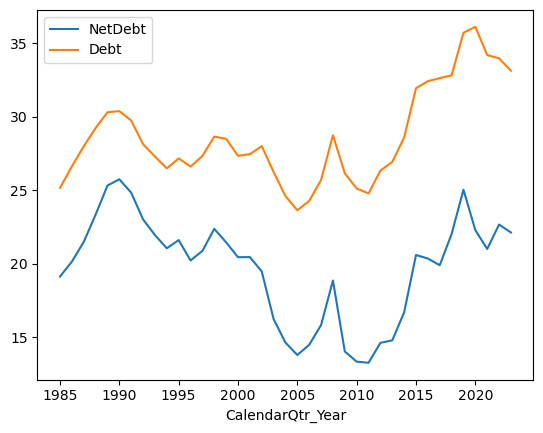

In [31]:
TempGroup = FlowPanel_A.groupby('CalendarQtr_Year')
WAggStockTS_A = TempGroup[['NetDebt', 'Debt']].sum().div(TempGroup['Asset'].sum(), axis=0)*100
WAggStockTS_A.plot()

In [32]:
WAggStockTS_A.loc[year1:year2, :].mean()

NetDebt    19.315544
Debt       28.591122
dtype: float64

### Non-weighted

<Axes: xlabel='CalendarQtr_Year'>

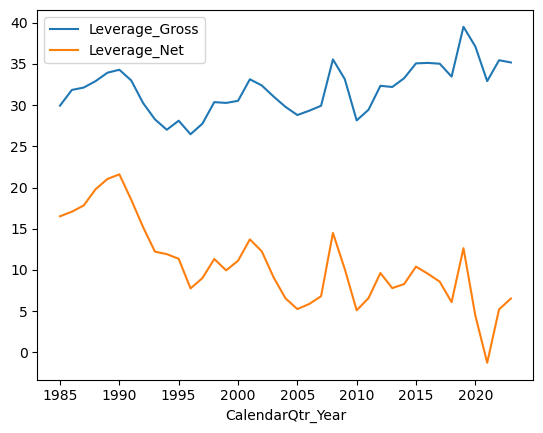

In [33]:
TempGroup = FlowPanel_A.groupby('CalendarQtr_Year')
AggStockTS_A = TempGroup[['Leverage_Gross', 'Leverage_Net']].mean()

AggStockTS_A.plot()

In [34]:
AggStockTS_A.mean()

Leverage_Gross    31.90193
Leverage_Net      10.66352
dtype: float64

## Investment Rate distribution

In [35]:
PctList = [0.001, 0.01,0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.995, 0.999]

### Raw data

In [36]:
temp = FlowPanel_A.loc[idx[:, year1:year2], 'CapExp_Rate'].copy()
print(temp.groupby('CalendarQtr_Year').describe(percentiles=PctList).mean())

count    4643.787879
mean        7.320925
std        25.378394
min      -117.762970
0.1%       -6.162511
1%         -0.048238
5%          0.103813
25%         1.423431
50%         3.381737
75%         7.127698
90%        14.525969
95%        23.400107
99%        63.656350
99.5%      96.714030
99.9%     268.782523
max      1061.022258
dtype: float64


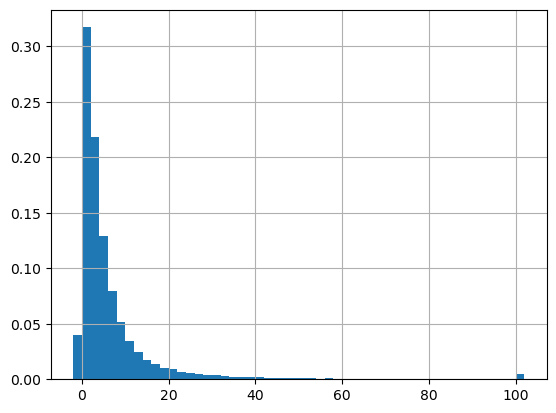

In [37]:
Cutoff_low = 0
Cutoff_upp = 100
Cutoff_num = 50
Cutoff_width = (Cutoff_upp-Cutoff_low)/Cutoff_num

CutoffList = [-np.inf] + list(np.linspace(Cutoff_low, Cutoff_upp, num=Cutoff_num+1)) + [np.inf]
Freq = pd.cut(temp, bins=CutoffList) \
         .groupby('CalendarQtr_Year').value_counts(normalize=True) \
         .unstack().mean().sort_index()

plt.hist([Cutoff_low-Cutoff_width/2]+[xx + Cutoff_width/2 for xx in CutoffList[1:-1]], \
         [Cutoff_low-(Cutoff_upp-Cutoff_low)/Cutoff_num] + CutoffList[1:-1] + [Cutoff_upp+(Cutoff_upp-Cutoff_low)/Cutoff_num], \
         weights=Freq)
plt.grid('on')

### Winsorized data

In [38]:
InvRate_upp = 200
InvRate_low = 0

temp = FlowPanel_A.loc[idx[:, year1:year2], 'CapExp_Rate'].copy()
temp.loc[temp<InvRate_low] = InvRate_low
temp.loc[temp>InvRate_upp] = InvRate_upp 

print(temp.groupby('CalendarQtr_Year').describe(percentiles=PctList).mean())

count    4643.787879
mean        6.902806
std        13.830397
min         0.000000
0.1%        0.000000
1%          0.000000
5%          0.103813
25%         1.423431
50%         3.381737
75%         7.127698
90%        14.525969
95%        23.400107
99%        63.656350
99.5%      94.693207
99.9%     176.215744
max       198.807779
dtype: float64


<Axes: xlabel='CalendarQtr_Year'>

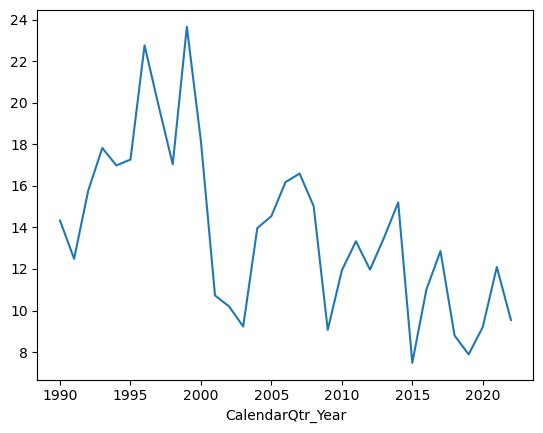

In [39]:
temp.groupby('CalendarQtr_Year').std().plot()

### Persistence

In [40]:
def Persistence(inputds, dt=1):
    tempds_level = inputds.copy().rename('level')
    tempds_lag = tempds_level.groupby('gvkey').shift(dt).rename('lag')
    tempds = pd.concat([tempds_level, tempds_lag], axis=1).dropna()

    corrcoef = tempds.corr().loc['lag', 'level']
    return corrcoef

0    1.000000
1    0.663134
2    0.543033
3    0.488415
4    0.463871
5    0.446227
6    0.433738
7    0.425899
8    0.415263
9    0.407169
Name: AutoCorr, dtype: float64


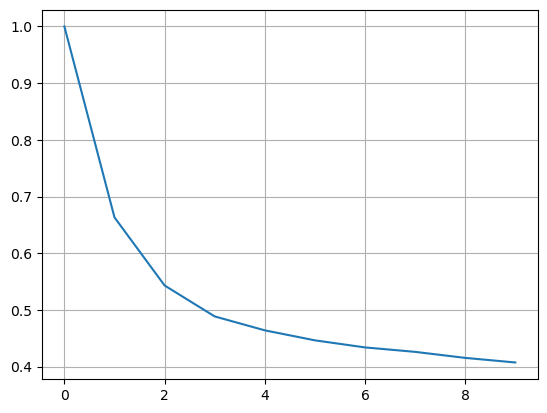

In [41]:
tempVar = 'CapExp_Rate'
temp = np.log(FlowPanel_A.loc[FlowPanel_A[tempVar]>0, tempVar]).dropna()
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)

## Log Investment distribution

### Raw data

In [42]:
temp = FlowPanel_A.loc[idx[:, year1:year2], 'LogCapExp'].copy()
temp = temp.loc[ np.isfinite(temp) ]
print(temp.groupby('CalendarQtr_Year').describe(percentiles=PctList).mean())

count    4560.545455
mean      179.164975
std       286.481730
min     -1099.408422
0.1%     -779.525033
1%       -522.318344
5%       -318.144811
25%       -13.839564
50%       201.511690
75%       379.108415
90%       529.963466
95%       620.203273
99%       783.620831
99.5%     837.430560
99.9%     928.931324
max       997.654753
dtype: float64


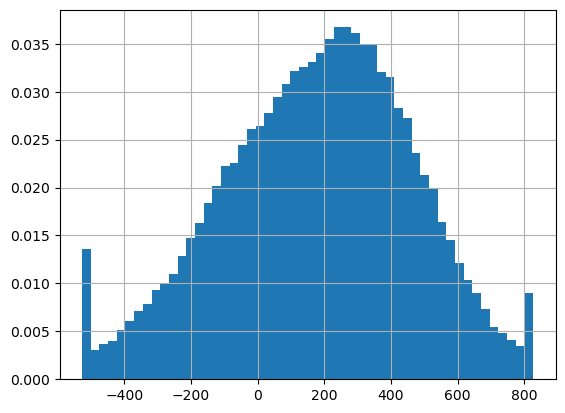

In [43]:
Cutoff_low = -500
Cutoff_upp = 800
Cutoff_num = 50
Cutoff_width = (Cutoff_upp-Cutoff_low)/Cutoff_num

CutoffList = [-np.inf] + list(np.linspace(Cutoff_low, Cutoff_upp, num=Cutoff_num+1)) + [np.inf]
Freq = pd.cut(temp, bins=CutoffList) \
         .groupby('CalendarQtr_Year').value_counts(normalize=True) \
         .unstack().mean().sort_index()

plt.hist([Cutoff_low-Cutoff_width/2]+[xx + Cutoff_width/2 for xx in CutoffList[1:-1]], \
         [Cutoff_low-(Cutoff_upp-Cutoff_low)/Cutoff_num] + CutoffList[1:-1] + [Cutoff_upp+(Cutoff_upp-Cutoff_low)/Cutoff_num], \
         weights=Freq)
plt.grid('on')

### Winsorized data

In [44]:
Wins_upp = 800
Wins_low = -500

temp.loc[temp<Wins_low] = Wins_low
temp.loc[temp>Wins_upp] = Wins_upp 

print(temp.groupby('CalendarQtr_Year').describe(percentiles=PctList).mean())

count    4560.545455
mean      180.036947
std       281.030450
min      -500.000000
0.1%     -500.000000
1%       -490.011654
5%       -318.144811
25%       -13.839564
50%       201.511690
75%       379.108415
90%       529.963466
95%       620.203273
99%       777.954205
99.5%     799.988316
99.9%     800.000000
max       800.000000
dtype: float64


<Axes: xlabel='CalendarQtr_Year'>

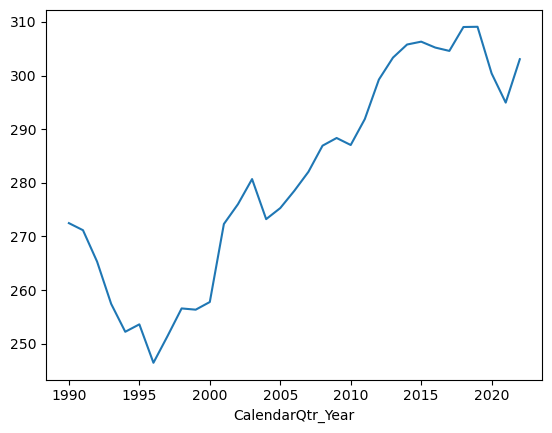

In [45]:
temp.groupby('CalendarQtr_Year').std().plot()

### Persistence

0    1.000000
1    0.920693
2    0.887946
3    0.870234
4    0.858901
5    0.849705
6    0.841319
7    0.834690
8    0.828199
9    0.822366
Name: AutoCorr, dtype: float64


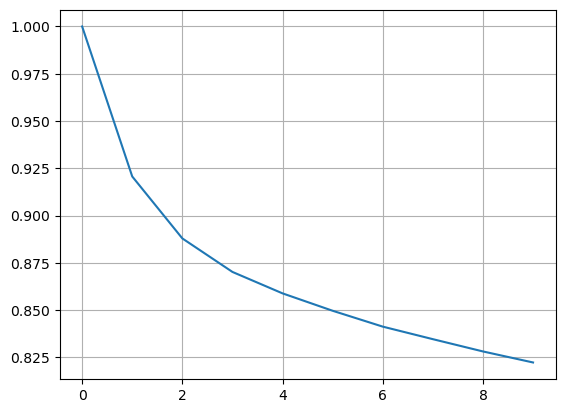

In [46]:
tempVar = 'LogCapExp'
temp = FlowPanel_A.loc[np.isfinite(FlowPanel_A[tempVar]), tempVar]
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)

## Sales-rate distribution

### Raw data

In [47]:
temp = FlowPanel_A.loc[idx[:, year1:year2], 'Sales_Rate'].copy()
print(temp.groupby('CalendarQtr_Year').describe(percentiles=PctList).mean())

count    4854.242424
mean      130.385384
std       223.468503
min       -21.919171
0.1%       -0.004043
1%          0.000000
5%          4.146493
25%        51.392043
50%        98.574139
75%       160.063517
90%       249.350455
95%       331.419151
99%       641.788544
99.5%     924.581792
99.9%    2109.795238
max      9460.897012
dtype: float64


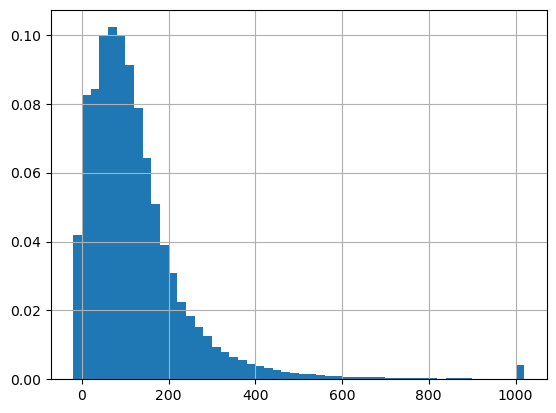

In [48]:
Cutoff_low = 0
Cutoff_upp = 1000
Cutoff_num = 50
Cutoff_width = (Cutoff_upp-Cutoff_low)/Cutoff_num

CutoffList = [-np.inf] + list(np.linspace(Cutoff_low, Cutoff_upp, num=Cutoff_num+1)) + [np.inf]
Freq = pd.cut(temp, bins=CutoffList) \
         .groupby('CalendarQtr_Year').value_counts(normalize=True) \
         .unstack().mean().sort_index()

plt.hist([Cutoff_low-Cutoff_width/2]+[xx + Cutoff_width/2 for xx in CutoffList[1:-1]], \
         [Cutoff_low-(Cutoff_upp-Cutoff_low)/Cutoff_num] + CutoffList[1:-1] + [Cutoff_upp+(Cutoff_upp-Cutoff_low)/Cutoff_num], \
         weights=Freq)
plt.grid('on')

### Winsorized data

In [49]:
InvRate_upp = 1000
InvRate_low = 0

temp = FlowPanel_A.loc[idx[:, year1:year2], 'Sales_Rate'].copy()
temp.loc[temp<InvRate_low] = InvRate_low
temp.loc[temp>InvRate_upp] = InvRate_upp 

print(temp.groupby('CalendarQtr_Year').describe(percentiles=PctList).mean())

count    4854.242424
mean      125.336637
std       122.569473
min         0.000000
0.1%        0.000000
1%          0.000000
5%          4.146493
25%        51.392043
50%        98.574139
75%       160.063517
90%       249.350455
95%       331.419151
99%       641.788544
99.5%     861.501700
99.9%    1000.000000
max      1000.000000
dtype: float64


### Persistency

0    1.000000
1    0.812178
2    0.716865
3    0.663620
4    0.625049
5    0.598237
6    0.577319
7    0.560706
8    0.545449
9    0.533646
Name: AutoCorr, dtype: float64


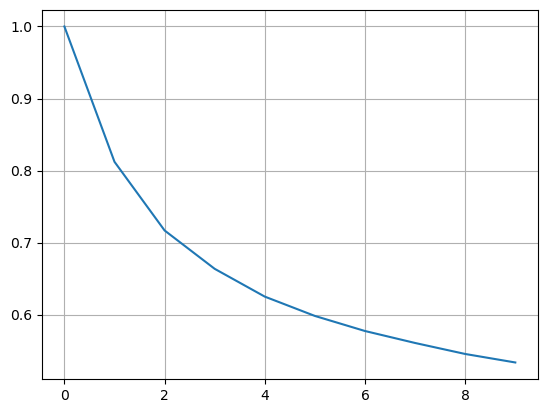

In [50]:
tempVar = 'Sales_Rate'
temp = np.log(FlowPanel_A.loc[FlowPanel_A[tempVar]>0, tempVar]).dropna()
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)

### Dispersion

In [51]:
InvRate_upp = 1000
InvRate_low = 0

temp = FlowPanel_A.loc[idx[:, year1:year2], 'Sales_Rate'].copy()
temp.loc[temp<InvRate_low] = InvRate_low
temp.loc[temp>InvRate_upp] = InvRate_upp 

temp = temp.loc[temp>0]
temp = temp.div(temp.groupby('CalendarQtr_Year').mean())

<Axes: xlabel='CalendarQtr_Year'>

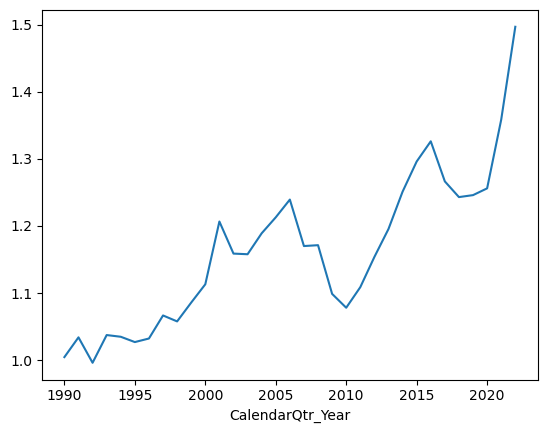

In [52]:
np.log(temp).groupby('CalendarQtr_Year').std().plot()

In [53]:
np.log(temp).groupby('CalendarQtr_Year').std().mean()

1.1627759028705011

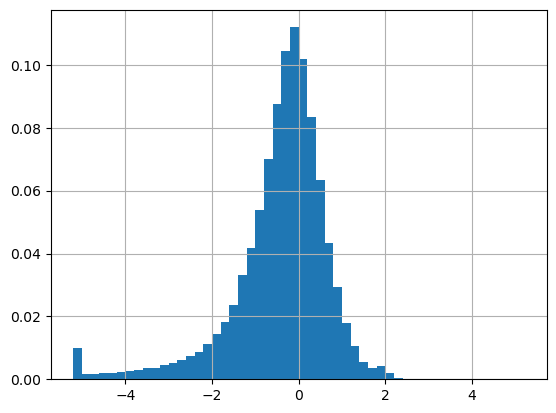

In [54]:
Cutoff_low = -5
Cutoff_upp = 5
Cutoff_num = 50
Cutoff_width = (Cutoff_upp-Cutoff_low)/Cutoff_num

CutoffList = [-np.inf] + list(np.linspace(Cutoff_low, Cutoff_upp, num=Cutoff_num+1)) + [np.inf]
Freq = pd.cut(np.log(temp), bins=CutoffList) \
         .groupby('CalendarQtr_Year').value_counts(normalize=True) \
         .unstack().mean().sort_index()

plt.hist([Cutoff_low-Cutoff_width/2]+[xx + Cutoff_width/2 for xx in CutoffList[1:-1]], \
         [Cutoff_low-(Cutoff_upp-Cutoff_low)/Cutoff_num] + CutoffList[1:-1] + [Cutoff_upp+(Cutoff_upp-Cutoff_low)/Cutoff_num], \
         weights=Freq)
plt.grid('on')

## Growth Rate

### Raw data

In [55]:
temp = FlowPanel_A.loc[idx[:, year1:year2], 'Growth_Rate'].copy()
print(temp.groupby('CalendarQtr_Year').describe(percentiles=PctList).mean())

count    4866.696970
mean        8.108323
std        47.541720
min      -374.738915
0.1%     -220.628352
1%       -107.142883
5%        -48.477479
25%        -9.101379
50%         2.221533
75%        17.573184
90%        52.546949
95%        88.756450
99%       181.757692
99.5%     226.277456
99.9%     317.525699
max       454.495787
dtype: float64


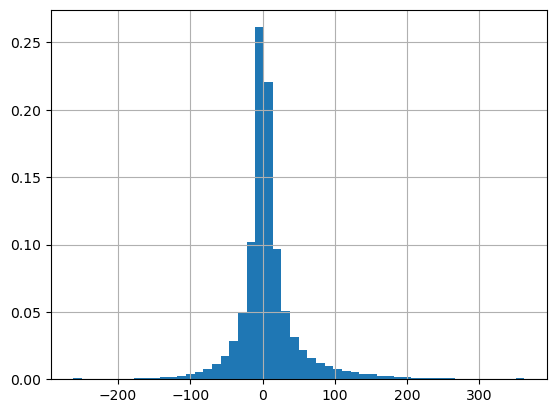

In [56]:
Cutoff_low = -250
Cutoff_upp = 350
Cutoff_num = 50
Cutoff_width = (Cutoff_upp-Cutoff_low)/Cutoff_num

CutoffList = [-np.inf] + list(np.linspace(Cutoff_low, Cutoff_upp, num=Cutoff_num+1)) + [np.inf]
Freq = pd.cut(temp, bins=CutoffList) \
         .groupby('CalendarQtr_Year').value_counts(normalize=True) \
         .unstack().mean().sort_index()

plt.hist([Cutoff_low-Cutoff_width/2]+[xx + Cutoff_width/2 for xx in CutoffList[1:-1]], \
         [Cutoff_low-(Cutoff_upp-Cutoff_low)/Cutoff_num] + CutoffList[1:-1] + [Cutoff_upp+(Cutoff_upp-Cutoff_low)/Cutoff_num], \
         weights=Freq)
plt.grid('on')

### Winsorized data

In [57]:
Wins_upp = 350
Wins_low = -250

temp = FlowPanel_A.loc[idx[:, year1:year2], 'Growth_Rate'].copy()
temp.loc[temp<Wins_low] = Wins_low
temp.loc[temp>Wins_upp] = Wins_upp 

print(temp.groupby('CalendarQtr_Year').describe(percentiles=PctList).mean())

count    4866.696970
mean        8.109769
std        46.691467
min      -248.485413
0.1%     -215.855840
1%       -107.142883
5%        -48.477479
25%        -9.101379
50%         2.221533
75%        17.573184
90%        52.546949
95%        88.756450
99%       181.757692
99.5%     225.868631
99.9%     306.223200
max       348.130061
dtype: float64


### Persistency

0    1.000000
1    0.116740
2    0.003529
3   -0.014351
4   -0.010522
5   -0.012266
6   -0.005904
7    0.006039
8   -0.003393
9   -0.011250
Name: AutoCorr, dtype: float64


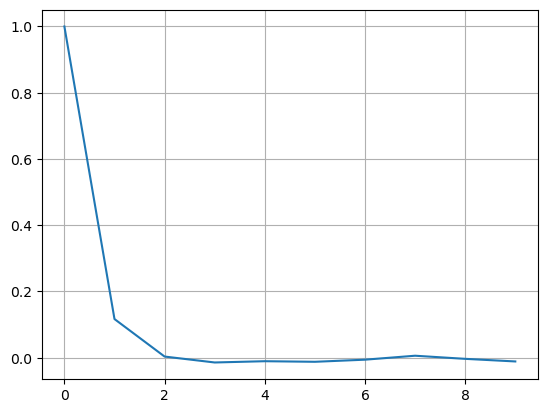

In [58]:
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)

### Dispersion

<Axes: xlabel='CalendarQtr_Year'>

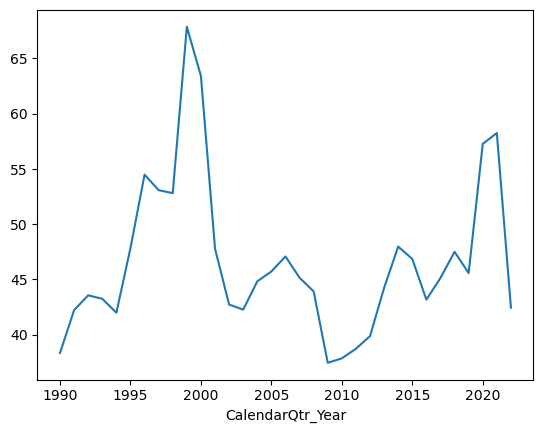

In [59]:
temp.groupby('CalendarQtr_Year').std().plot()

In [60]:
temp.groupby('CalendarQtr_Year').std().mean()

46.691466632997944

## Size distribution

In [61]:
temp = np.log(FlowPanel_A['Lag_Asset'].div(FlowPanel_A.groupby('CalendarQtr_Year')['Lag_Asset'].mean()))

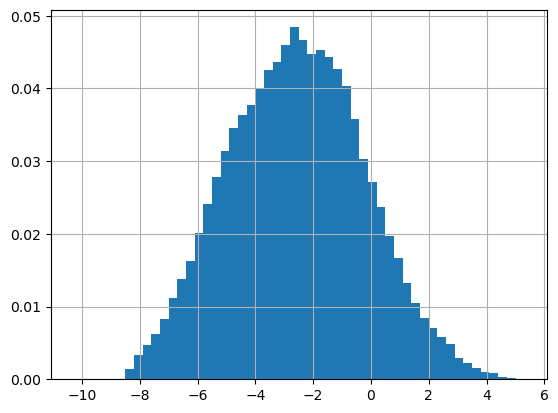

In [62]:
Cutoff_low = -10
Cutoff_upp = 5
Cutoff_num = 50
Cutoff_width = (Cutoff_upp-Cutoff_low)/Cutoff_num

CutoffList = [-np.inf] + list(np.linspace(Cutoff_low, Cutoff_upp, num=Cutoff_num+1)) + [np.inf]
Freq = pd.cut(temp, bins=CutoffList) \
         .groupby('CalendarQtr_Year').value_counts(normalize=True) \
         .unstack().mean().sort_index()

plt.hist([Cutoff_low-Cutoff_width/2]+[xx + Cutoff_width/2 for xx in CutoffList[1:-1]], \
         [Cutoff_low-(Cutoff_upp-Cutoff_low)/Cutoff_num] + CutoffList[1:-1] + [Cutoff_upp+(Cutoff_upp-Cutoff_low)/Cutoff_num], \
         weights=Freq)
plt.grid('on')

In [63]:
LogSize_upp = 8

temp.loc[temp<-LogSize_upp] = -LogSize_upp
temp.loc[temp>LogSize_upp] = LogSize_upp


In [64]:
print(temp.groupby('CalendarQtr_Year').describe(percentiles=[0.01,0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.995, 0.999]).mean())

count    4752.307692
mean       -2.564192
std         2.338041
min        -7.564358
1%         -7.344242
5%         -6.406658
25%        -4.285153
50%        -2.558316
75%        -0.936466
90%         0.469399
95%         1.325233
99%         2.867026
99.5%       3.356231
99.9%       4.191775
max         4.798832
dtype: float64


In [65]:
qlist = list(np.linspace(0,1, num=5+1)*100)
def TempFun(ds):
    tempds = ds.loc[np.isfinite(ds)]
    CutoffList = np.percentile(tempds, q=qlist)
    SizeGroup = pd.cut(tempds, bins=CutoffList, labels=qlist[1:])
    temp = pd.concat([tempds.rename('Size'), SizeGroup.rename('SizeGroup')], axis=1)
    tempAgg = temp.groupby('SizeGroup')['Size'].sum()
    tempAgg = tempAgg / tempAgg.sum()
    return tempAgg 

In [66]:
np.exp(temp.loc[idx[:, year1:year2]]).groupby('CalendarQtr_Year').apply(TempFun).unstack().mean()

C:\Users\guoxi\AppData\Local\Temp\ipykernel_15948\2957512227.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tempAgg = temp.groupby('SizeGroup')['Size'].sum()


SizeGroup
20.0                 0.000820
40.0                 0.004493
60.00000000000001    0.016962
80.0                 0.062253
100.0                0.915473
dtype: float64

## Exit Rate

In [67]:
FlowPanel_A = FlowPanel_A.reset_index()
FlowPanel_A['Year'] = FlowPanel_A['CalendarQtr_Year']
FlowPanel_A = FlowPanel_A.set_index(['gvkey', 'CalendarQtr_Year']).sort_index()

In [68]:
FlowPanel_A = FlowPanel_A.join(FlowPanel_A.groupby('gvkey')['Year'].agg(['min', 'max']).rename(columns={'min': 'Year_min', 'max': 'Year_max'}))

In [69]:
FlowPanel_A['ExitFlag'] = FlowPanel_A['Year']==FlowPanel_A['Year_max']

### Time-series

<Axes: xlabel='CalendarQtr_Year'>

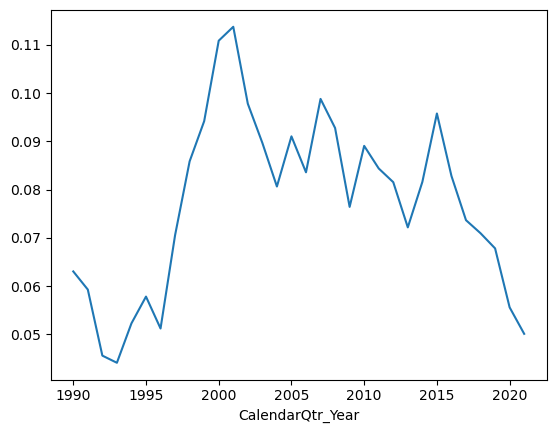

In [70]:
FlowPanel_A.groupby('CalendarQtr_Year')['ExitFlag'].mean().loc[year1:2021].plot()

### Average

In [71]:
# Average probability of exit
FlowPanel_A.groupby('CalendarQtr_Year')['ExitFlag'].mean().loc[year1:year2].mean()* 100

7.717096925920583

# Moments based on Regression

## Prepare the data

In [72]:
FirstYear = DS.groupby('gvkey')[['year1', 'year2', 'IpoYear']].min()
Sector = DS.groupby('gvkey').tail(1).set_index('gvkey')[['FF10_Code', 'sic']]

In [73]:
TempDS = FlowPanel_A.join(FirstYear).join(Sector).reset_index()
TempDS = TempDS.loc[(TempDS['CalendarQtr_Year']>=year1) & (TempDS['CalendarQtr_Year']<=year2), :]
TempDS['Year'] = TempDS['CalendarQtr_Year']
TempDS = TempDS.set_index(['gvkey', 'CalendarQtr_Year']).sort_index()

In [74]:
TempDS 

CapExp  EquityIssuance     Payout  OptCashFlow  \
gvkey  CalendarQtr_Year                                                      
001003 1990               0.024376        0.000000   0.015237    -0.856615   
001004 1990              28.302407        0.000000  16.394737    47.866236   
       1991              12.630574        0.000000  12.109057    33.253512   
       1992              18.275223        0.000000  13.615296    22.173525   
       1993               7.475797        0.000000  11.572550    38.264057   
...                            ...             ...        ...          ...   
348784 2022                    NaN             NaN        NaN          NaN   
349530 2021               0.379439       96.067104  -0.934800   -30.858755   
       2022               0.125630        0.000000   0.000000    -8.255624   
349972 2021               0.000000        0.000000   0.000000   -12.211043   
       2022               0.000000        0.000000   0.000000   -10.794326   

                              Sales       Asset     NetDebt        Debt  \
gvkey  CalendarQtr_Year                                                   
001003 1990               20.534080   10.952498    6.915305    7.351185   
001004 1990              760.703355  620.594018  163.666363  170.684502   
       1991              705.035883  614.540026  148.084585  154.049452   
       1992              641.670861  615.522218  154.797602  162.318544   
       1993              567.299971  613.668483  132.209694  175.282958   
...                             ...         ...         ...         ...   
348784 2022                0.000000   73.892107  -14.638987    0.635147   
349530 2021                1.240238  104.312146   -7.237803   11.232262   
       2022                2.415922   84.153645    3.351560    5.675610   
349972 2021                0.000000   34.992055  -33.600203    0.145739   
       2022                0.000000   22.741337  -21.354848    0.064827   

                          Lag_Asset  Lag_NetDebt  ...   LogCapExp  Year  \
gvkey  CalendarQtr_Year                           ...                     
001003 1990               17.012391     6.452221  ... -371.416050  1990   
001004 1990              629.719303   167.167059  ...  334.294686  1990   
       1991              620.594018   163.666363  ...  253.612040  1991   
       1992              614.540026   148.084585  ...  290.554621  1992   
       1993              615.522218   154.797602  ...  201.167072  1993   
...                             ...          ...  ...         ...   ...   
348784 2022                     NaN          NaN  ...         NaN  2022   
349530 2021                     NaN          NaN  ...  -96.906093  2021   
       2022              104.312146    -7.237803  ... -207.441393  2022   
349972 2021                     NaN          NaN  ...        -inf  2021   
       2022               34.992055   -33.600203  ...        -inf  2022   

                         Year_min  Year_max  ExitFlag   year1   year2  \
gvkey  CalendarQtr_Year                                                 
001003 1990                  1985      1990      True  1980.0  1989.0   
001004 1990                  1985      2023     False  1965.0  2023.0   
       1991                  1985      2023     False  1965.0  2023.0   
       1992                  1985      2023     False  1965.0  2023.0   
       1993                  1985      2023     False  1965.0  2023.0   
...                           ...       ...       ...     ...     ...   
348784 2022                  2022      2022      True  2022.0  2023.0   
349530 2021                  2021      2022     False  2021.0  2021.0   
       2022                  2021      2022      True  2021.0  2021.0   
349972 2021                  2021      2023     False  2020.0  2023.0   
       2022                  2021      2023     False  2020.0  2023.0   

                         IpoYear  FF10_Code     sic  
gvkey  CalendarQtr_Year                              
001

## Trim the sample for regression

In [75]:
# Trim the Extreme Values
TrimDict = {'CapExp_Rate': [0.01,0.995], 'EquityIssuance_Rate': [0.005,0.995], 'OptCashFlow_Rate': [0.01,0.99], \
            'LogCapExp': [0.01, 0.995] \
            }
           
TempQuantList = [0.001,0.005,0.01,0.05,0.1,0.9,0.95,0.99,0.995,0.999]
print('\n Pre-winsorization Quantiles: \n')
print(np.round(TempDS[list(TrimDict.keys())].quantile(TempQuantList).transpose(),2))

TempInd = ~pd.isnull(TempDS['Lag_Asset'])
for vv in TrimDict.keys():
    Cutoff = TempDS[vv].quantile(TrimDict[vv]).tolist()
    TempInd = TempInd & ~( TempDS[vv]<Cutoff[0] )
    TempInd = TempInd & ~( TempDS[vv]>Cutoff[1] )

Obs_0 = TempDS.shape[0]
TempDS = TempDS.loc[TempInd,:]
Obs_1 = TempDS.shape[0]
print('Winsorization Step Drops ',np.round((1-Obs_1/Obs_0)*100,2),"% obs.\n")
print('\n Post-winsorization Quantiles: \n')
print(np.round(TempDS[list(TrimDict.keys())].quantile(TempQuantList).transpose(),2))



 Pre-winsorization Quantiles: 

                      0.001   0.005   0.010   0.050   0.100   0.900   0.950  \
CapExp_Rate           -6.97   -0.26    0.00    0.06    0.38   15.54   25.14   
EquityIssuance_Rate   -0.00    0.00    0.00    0.00    0.00   38.33  112.41   
OptCashFlow_Rate    -741.65 -331.27 -224.37  -72.94  -38.56   21.19   28.28   
LogCapExp               NaN     NaN     NaN -459.30 -259.92  522.30  614.39   

                      0.990    0.995    0.999  
CapExp_Rate           69.18   108.40   320.51  
EquityIssuance_Rate  587.17  1011.67  3051.85  
OptCashFlow_Rate      55.44    76.88   198.89  
LogCapExp            783.11   831.22   935.87  
Winsorization Step Drops  10.05 % obs.


 Post-winsorization Quantiles: 

                      0.001   0.005   0.010   0.050   0.100   0.900   0.950  \
CapExp_Rate            0.00    0.00    0.00    0.10    0.42   14.49   22.51   
EquityIssuance_Rate    0.00    0.00    0.00    0.00    0.00   30.36   84.95   
OptCashFlow_Rate    

c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [76]:
TempDS = TempDS.join(TempDS.groupby('gvkey')['Lag_Asset'].count().rename('FirmObs'))

<Axes: xlabel='FirmObs'>

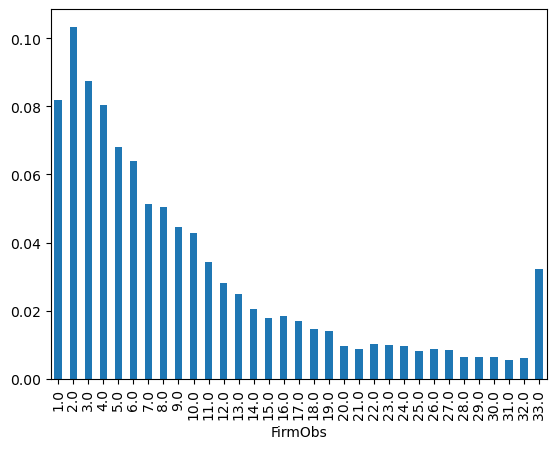

In [77]:
TempDS.groupby('gvkey')['FirmObs'].mean().value_counts(normalize=True).sort_index().plot(kind='bar')

In [78]:
TempDS['Age'] = TempDS['Year']-TempDS['year1']
TempDS['IpoAge'] = TempDS['Year']-TempDS['IpoYear']

In [79]:
temp = TempDS.groupby('Year')['Age'].value_counts(normalize=True).unstack().mean().rename('Prob').reset_index()
temp['AgeGroup'] = pd.cut(temp['Age'], bins=[-10]+[5*(ii+1) for ii in range(5)]+[np.Inf])
temp.groupby('AgeGroup')['Prob'].sum()

C:\Users\guoxi\AppData\Local\Temp\ipykernel_15948\3974868811.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby('AgeGroup')['Prob'].sum()


AgeGroup
(-10.0, 5.0]    0.220055
(5.0, 10.0]     0.235705
(10.0, 15.0]    0.139097
(15.0, 20.0]    0.109516
(20.0, 25.0]    0.082076
(25.0, inf]     0.354993
Name: Prob, dtype: float64

<Axes: xlabel='Age'>

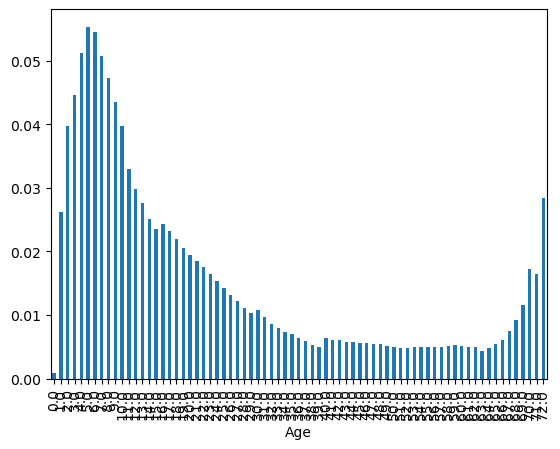

In [80]:
TempDS.groupby('Year')['Age'].value_counts(normalize=True).unstack().mean().sort_index().loc[0:].plot(kind='bar')

<Axes: xlabel='IpoAge'>

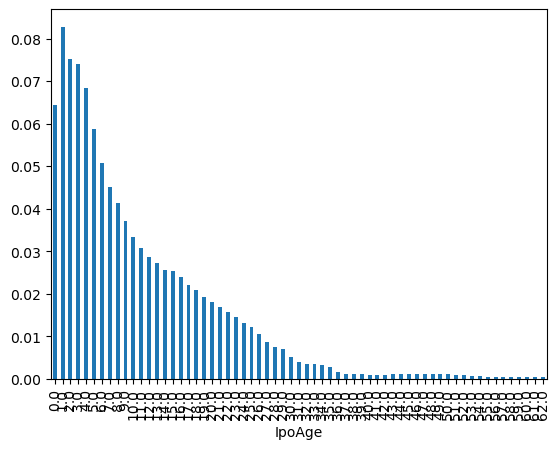

In [81]:
TempDS.groupby('Year')['IpoAge'].value_counts(normalize=True).unstack().mean().sort_index().loc[0:].plot(kind='bar')

In [82]:
TempDS['CapExp_PosFlag'] = (TempDS['CapExp_Rate']>1e-2)*1
TempDS['EquityIssuance_PosFlag'] = (TempDS['EquityIssuance_Rate']>1e-2)*1
TempDS['Lag_LogAsset'] = np.log(TempDS['Lag_Asset'])
TempDS['Log_OptCashFlow_Rate'] = np.log(TempDS['OptCashFlow_Rate'])
TempDS['Log_Sales_Rate'] = np.log(TempDS['Sales_Rate'])

c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\guoxi\anaconda3\envs\FirmHete_AsymInfo\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [83]:
stata.pdataframe_to_data(TempDS.reset_index(),force=True)
stata.run('encode gvkey, gen(gvkey_code)')
stata.run('xtset gvkey_code Year')


Panel variable: gvkey_code (unbalanced)
 Time variable: Year, 1990 to 2022, but with gaps
         Delta: 1 unit


In [84]:
def UnitReg(YVar, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction, WeightVar='', RegCommand='reghdfe', Level=90):
    # Compose the Stata Command
    OptionList = []
    OptionList.append('noabsorb') if len(AbsorbVarList)==0 else OptionList.append('absorb('+' '.join(AbsorbVarList)+')')
    if RegCommand=='ivreghdfe':
        if len(ClusterVarList)>0:
            OptionList.append('cluster('+' '.join(ClusterVarList)+')')
    elif RegCommand=='reghdfe':
        OptionList.append('vce(cluster'+' '.join(ClusterVarList)+')')

    OptionList.append('level('+str(Level)+')')
    # Run regression
    print('Start running regression for',YVar,':')
    StataCommand = ' '.join([RegCommand,YVar]+XVarList+[SampleRestriction])+('' if len(WeightVar)==0 else ' [weight='+WeightVar+']')+', '+' '.join(OptionList)
    stata.run(StataCommand, quietly=True)
    # Collect the results
    RegResults = stata.get_ereturn()
    if RegCommand=='ivreghdfe':
        VarList = RegResults['e(instd)'].split(' ') + RegResults['e(inexog)'].split(' ')
    else:
        VarList = RegResults['e(indepvars)'].split(' ')

    Coef = RegResults['e(b)'][0]
    SE = np.sqrt(RegResults['e(V)'].diagonal())
    DoF = RegResults['e(df_r)']

    Idx = SE!=0
    Coef = Coef[Idx]
    SE = SE[Idx]

    TValue = Coef/SE
    PValue = TDist.cdf(-np.abs(TValue),df=DoF)+TDist.sf(np.abs(TValue),df=DoF)

    TDistQuant = TDist.ppf(q=[(1-Level/100)/2,1-(1-Level/100)/2],df=DoF)
    CI_Left = Coef + TDistQuant[0]*SE
    CI_Right = Coef + TDistQuant[1]*SE

    RegTable = pd.concat([pd.Series(xx,index=VarList) for xx in [Coef,SE,TValue,PValue,CI_Left,CI_Right]],axis=1,keys=['Coef', 'SE', 'TValue', 'PValue', 'CI_Left', 'CI_Right'])

    print('Done.')

    return RegTable

## Life-cycle difference

In [85]:
# stata.run('drop age_group')
stata.run('gen age_group = 0')
stata.run('replace age_group = 5 if Age>5')

stata.run('replace age_group = 10 if Age>10')
stata.run('replace age_group = 15 if Age>15')
stata.run('replace age_group = 20 if Age>20')
stata.run('replace age_group = 25 if Age>25')

(119,532 real changes made)
(81,146 real changes made)
(59,541 real changes made)
(43,351 real changes made)
(31,499 real changes made)


In [86]:
# stata.run('drop age_group')
stata.run('gen age_group2 = 0')
stata.run('replace age_group2 = 5 if Age>5')

(119,532 real changes made)


In [87]:
# stata.run('drop ipoage_group')
stata.run('gen ipoage_group = 0')
stata.run('replace ipoage_group = 5 if IpoAge>5')

stata.run('replace ipoage_group = 10 if IpoAge>10')
stata.run('replace ipoage_group = 15 if IpoAge>15')
stata.run('replace ipoage_group = 20 if IpoAge>20')
stata.run('replace ipoage_group = 25 if IpoAge>25')

(117,020 real changes made)
(99,374 real changes made)
(88,915 real changes made)
(82,440 real changes made)
(78,358 real changes made)


In [88]:
stata.run('gen Flag_PosEquIss = (EquityIssuance_Rate>1e-4)*1')

In [89]:
def TempPlot_ErrBar(X,Y, E_low, E_upp,Color,Label):
    plt.errorbar(X, Y, yerr=[E_low, E_upp], ecolor=MyGR.MyColor(Color, 1), color=MyGR.MyColor(Color, 0.5), lw=0.3, elinewidth=2, capsize=3, capthick=0.5, label=Label, marker='o', ms=3)
    return 

In [90]:
def TempPlot_LifeCycle(ax, ds, label=''):

    temp = ds.drop('_cons', axis=0)
    temp.index = [int(xx.split('.')[0].replace('bn', '')) for xx in temp.index]
    temp.loc[0, :] = 0
    temp = temp.sort_index()

    TempPlot_ErrBar(range(temp.shape[0]), temp['Coef'], temp['Coef']-temp['CI_Left'], temp['CI_Right']-temp['Coef'], "Blue", 'Lag_LogAsset')

    plt.hlines(0, 0, temp.shape[0]-1, colors=MyGR.MyColor("Gray", 0.5))
    plt.grid('on',axis='both',linestyle='dashed',color=MyGR.MyColor('Gray',0.5)) 
    ax.set_xlabel("Age group", fontsize=6)
    ax.set_title(label, fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    return ax

### Filter by sector-year + Firm FE

In [91]:
AbsorbVarList = ['i.sic#i.Year', 'i.gvkey_code']
ClusterVarList = ['i.gvkey_code', 'i.Year']

XVarList = ['i.age_group']
YVarList = ['Lag_LogAsset', 'Growth_Rate', 'CapExp_Rate', 'LogCapExp', 'EquityIssuance_Rate', 'OptCashFlow_Rate', 'EquityIssuance_PosFlag', 'CapExp_PosFlag', 'Log_Sales_Rate', 'Log_OptCashFlow_Rate', 'Lag_Leverage_Gross', 'Lag_Leverage_Net']

In [92]:
ResultDict = {}
SampleCondition = "if FirmObs>=10"

for yy in YVarList:
    if yy in ['EquityIssuance_PosFlag', 'CapExp_PosFlag', 'Lag_LogAsset']:
        ResultDict[yy] = UnitReg(yy, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction=SampleCondition, WeightVar='')
    else:
        ResultDict[yy] = UnitReg(yy, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction=SampleCondition, WeightVar='')

Start running regression for Lag_LogAsset :
Done.
Start running regression for Growth_Rate :
Done.
Start running regression for CapExp_Rate :
Done.
Start running regression for LogCapExp :
Done.
Start running regression for EquityIssuance_Rate :
Done.
Start running regression for OptCashFlow_Rate :
Done.
Start running regression for EquityIssuance_PosFlag :
Done.
Start running regression for CapExp_PosFlag :
Done.
Start running regression for Log_Sales_Rate :
Done.
Start running regression for Log_OptCashFlow_Rate :
Done.
Start running regression for Lag_Leverage_Gross :
Done.
Start running regression for Lag_Leverage_Net :
Done.


In [93]:
pd.concat([ResultDict[yy]['Coef'].rename(yy) for yy in YVarList], axis=1)

,Lag_LogAsset,Growth_Rate,CapExp_Rate,LogCapExp,EquityIssuance_Rate,OptCashFlow_Rate,EquityIssuance_PosFlag,CapExp_PosFlag,Log_Sales_Rate,Log_OptCashFlow_Rate,Lag_Leverage_Gross,Lag_Leverage_Net
5bn.age_group,0.340597,-12.418416,-2.239742,7.767625,-23.825348,4.063195,-0.087021,0.065252,-0.028126,-0.053186,-0.111253,2.558403
10bn.age_group,0.407441,-13.490893,-2.578616,14.556168,-23.472510,4.549962,-0.113213,0.055143,0.007027,-0.055543,2.710251,6.968357
15bn.age_group,0.465374,-13.150232,-2.614100,23.213891,-20.714482,3.650193,-0.119721,0.043036,0.047113,-0.064563,2.660036,7.292367
20bn.age_group,0.518593,-12.085711,-2.559181,31.068052,-18.526530,3.738322,-0.118742,0.034025,0.071402,-0.085986,4.074510,9.108947
25bn.age_group,0.570080,-11.120505,-2.409894,40.020763,-15.265411,2.903192,-0.108814,0.023207,0.066793,-0.093255,5.025628,9.539906
_cons,5.048210,15.806268,8.272610,187.810500,28.023703,-1.779069,0.247484,0.911319,4.478577,2.250504,24.234973,1.171342


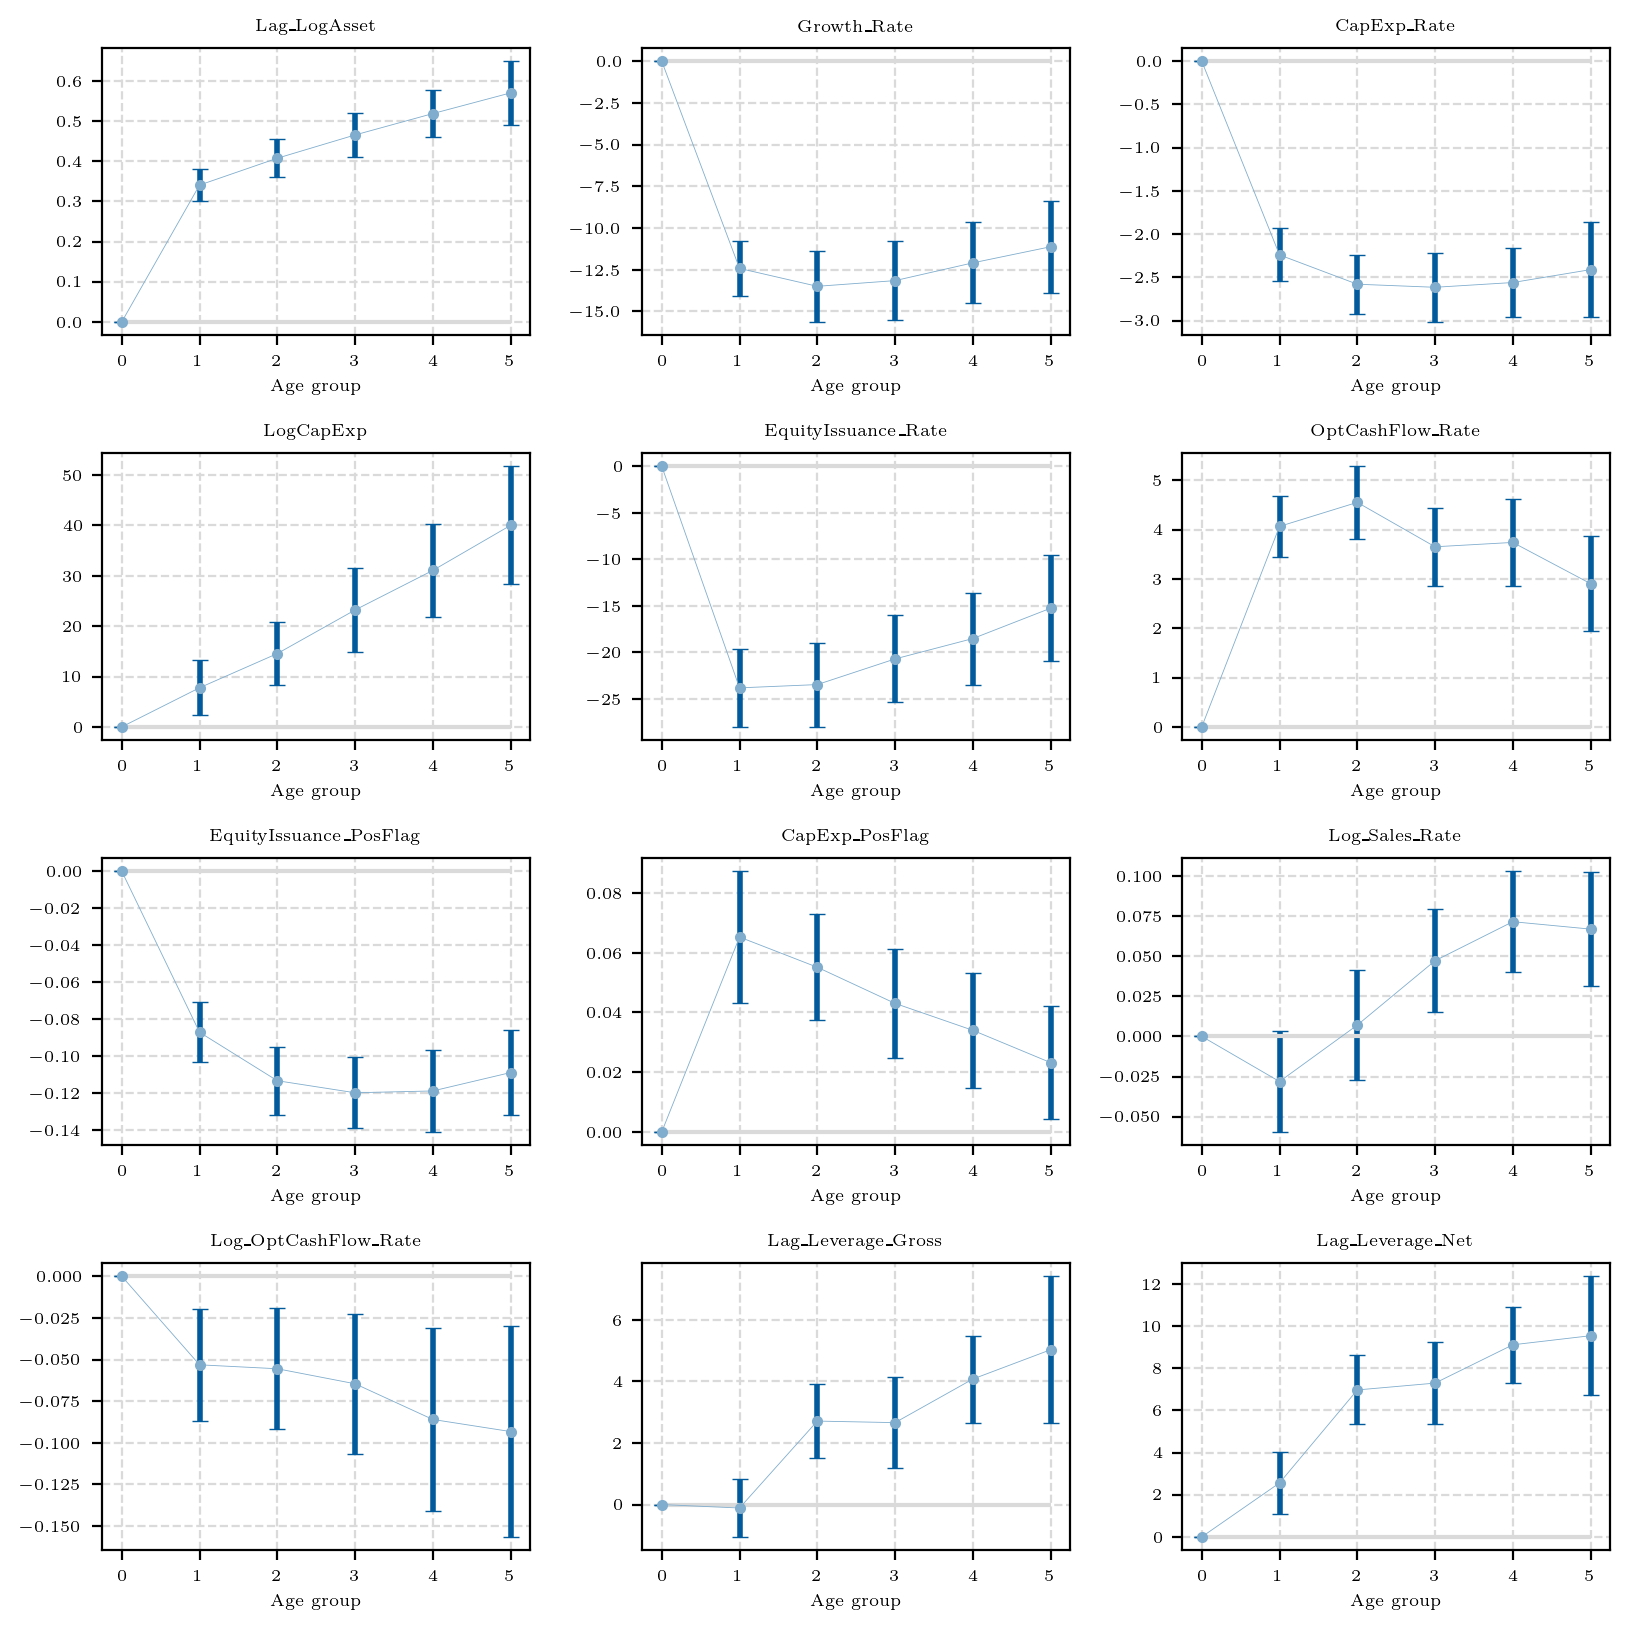

In [94]:
Fig = MyGR.Setup_Fig(FigSize=(1/2 * 2, 1/4 * 4))
for (ii, vv) in enumerate(YVarList):
    ax = Fig.add_subplot(4,3,ii+1)
    TempPlot_LifeCycle(ax, ResultDict[vv], label=vv)

plt.tight_layout()

In [95]:
ResultDict = {}
XVarList = ['i.ipoage_group']
SampleCondition = "if FirmObs>=10"

for yy in YVarList:
    if yy in ['EquityIssuance_PosFlag', 'CapExp_PosFlag', 'Lag_LogAsset']:
        ResultDict[yy] = UnitReg(yy, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction=SampleCondition, WeightVar='')
    else:
        ResultDict[yy] = UnitReg(yy, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction=SampleCondition, WeightVar='')

Start running regression for Lag_LogAsset :
Done.
Start running regression for Growth_Rate :
Done.
Start running regression for CapExp_Rate :
Done.
Start running regression for LogCapExp :
Done.
Start running regression for EquityIssuance_Rate :
Done.
Start running regression for OptCashFlow_Rate :
Done.
Start running regression for EquityIssuance_PosFlag :
Done.
Start running regression for CapExp_PosFlag :
Done.
Start running regression for Log_Sales_Rate :
Done.
Start running regression for Log_OptCashFlow_Rate :
Done.
Start running regression for Lag_Leverage_Gross :
Done.
Start running regression for Lag_Leverage_Net :
Done.


In [96]:
pd.concat([ResultDict[yy]['Coef'].rename(yy) for yy in YVarList], axis=1)

,Lag_LogAsset,Growth_Rate,CapExp_Rate,LogCapExp,EquityIssuance_Rate,OptCashFlow_Rate,EquityIssuance_PosFlag,CapExp_PosFlag,Log_Sales_Rate,Log_OptCashFlow_Rate,Lag_Leverage_Gross,Lag_Leverage_Net
5bn.ipoage_group,0.283715,-9.587584,-1.805514,8.121854,-17.484536,2.699285,-0.073075,0.038760,0.004665,-0.054227,1.090308,5.096826
10bn.ipoage_group,0.295599,-9.958957,-1.828515,11.491456,-16.175207,3.361560,-0.089575,0.021814,0.057537,-0.032745,2.460492,7.881689
15bn.ipoage_group,0.349978,-7.886190,-1.717874,22.281919,-12.741804,2.911023,-0.088886,0.010019,0.087330,-0.034747,2.894033,9.208936
20bn.ipoage_group,0.404231,-8.056155,-1.837267,25.527630,-11.982593,2.711061,-0.083978,0.002369,0.086099,-0.064647,4.271127,11.700565
25bn.ipoage_group,0.515844,-7.505584,-1.475284,45.992324,-9.797259,2.883693,-0.073164,-0.016698,-0.002895,-0.038116,4.947811,12.346191
_cons,5.079289,12.014727,7.485234,180.288826,20.687464,-1.007535,0.218769,0.949895,4.493253,2.220110,23.481723,-1.561496


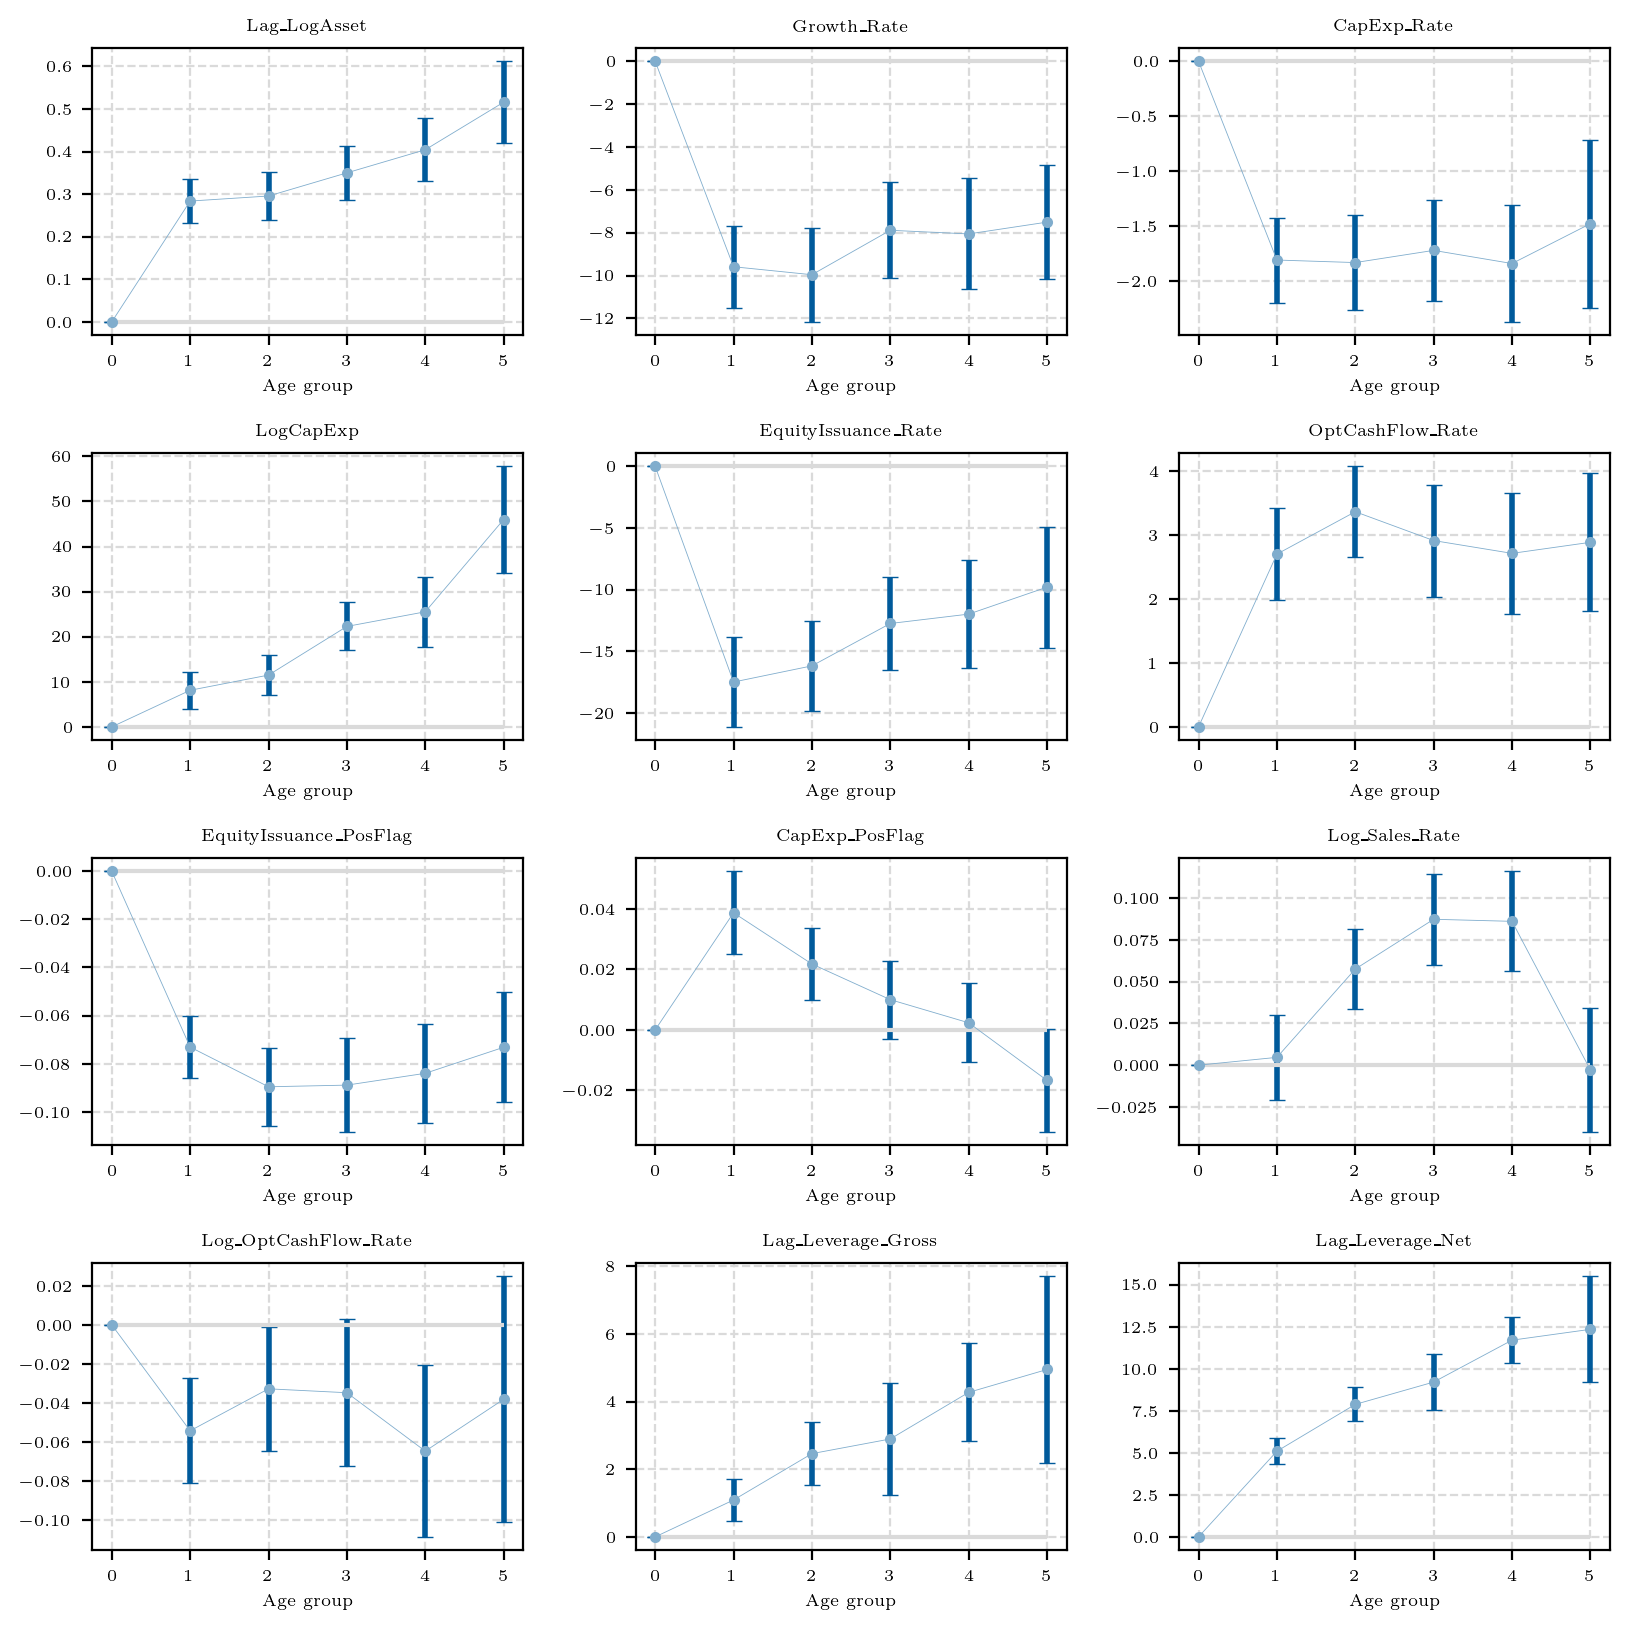

In [97]:
Fig = MyGR.Setup_Fig(FigSize=(1/2 * 2, 1/4 * 4))
for (ii, vv) in enumerate(YVarList):
    ax = Fig.add_subplot(4,3,ii+1)
    TempPlot_LifeCycle(ax, ResultDict[vv], label=vv)

plt.tight_layout()

### Filter by sector-year FE

In [98]:
AbsorbVarList = ['i.sic#i.Year']
ClusterVarList = ['i.gvkey_code', 'i.Year']

XVarList = ['i.age_group']

In [99]:
ResultDict = {}
SampleCondition = "if FirmObs>=10"

for yy in YVarList:
    if yy in ['EquityIssuance_PosFlag', 'CapExp_PosFlag', 'Lag_LogAsset']:
        ResultDict[yy] = UnitReg(yy, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction=SampleCondition, WeightVar='')
    else:
        ResultDict[yy] = UnitReg(yy, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction=SampleCondition, WeightVar='')

Start running regression for Lag_LogAsset :
Done.
Start running regression for Growth_Rate :
Done.
Start running regression for CapExp_Rate :
Done.
Start running regression for LogCapExp :
Done.
Start running regression for EquityIssuance_Rate :
Done.
Start running regression for OptCashFlow_Rate :
Done.
Start running regression for EquityIssuance_PosFlag :
Done.
Start running regression for CapExp_PosFlag :
Done.
Start running regression for Log_Sales_Rate :
Done.
Start running regression for Log_OptCashFlow_Rate :
Done.
Start running regression for Lag_Leverage_Gross :
Done.
Start running regression for Lag_Leverage_Net :
Done.


In [100]:
pd.concat([ResultDict[yy]['Coef'].rename(yy) for yy in YVarList], axis=1)

,Lag_LogAsset,Growth_Rate,CapExp_Rate,LogCapExp,EquityIssuance_Rate,OptCashFlow_Rate,EquityIssuance_PosFlag,CapExp_PosFlag,Log_Sales_Rate,Log_OptCashFlow_Rate,Lag_Leverage_Gross,Lag_Leverage_Net
5bn.age_group,0.358677,-13.766649,-2.366006,14.963210,-26.803750,5.725413,-0.101409,0.067748,-0.032754,-0.066893,-0.076103,3.688112
10bn.age_group,0.423685,-16.187106,-2.884377,20.740744,-30.118978,7.563833,-0.142843,0.063299,0.007520,-0.064221,2.130317,8.450037
15bn.age_group,0.489358,-16.727293,-3.039799,27.842875,-31.044124,8.533671,-0.166422,0.059908,0.050511,-0.046554,0.477054,7.914156
20bn.age_group,0.679002,-16.318379,-3.131198,46.869500,-31.987292,10.169101,-0.182900,0.058397,0.079651,-0.050350,0.335824,9.133604
25bn.age_group,1.659991,-16.665469,-3.281065,149.441477,-33.376982,12.369656,-0.210063,0.074234,0.078205,-0.051722,-1.279948,9.052926
_cons,4.732770,18.907370,8.700418,153.442451,37.322030,-6.469266,0.294943,0.891175,4.474728,2.234266,26.667893,0.741532


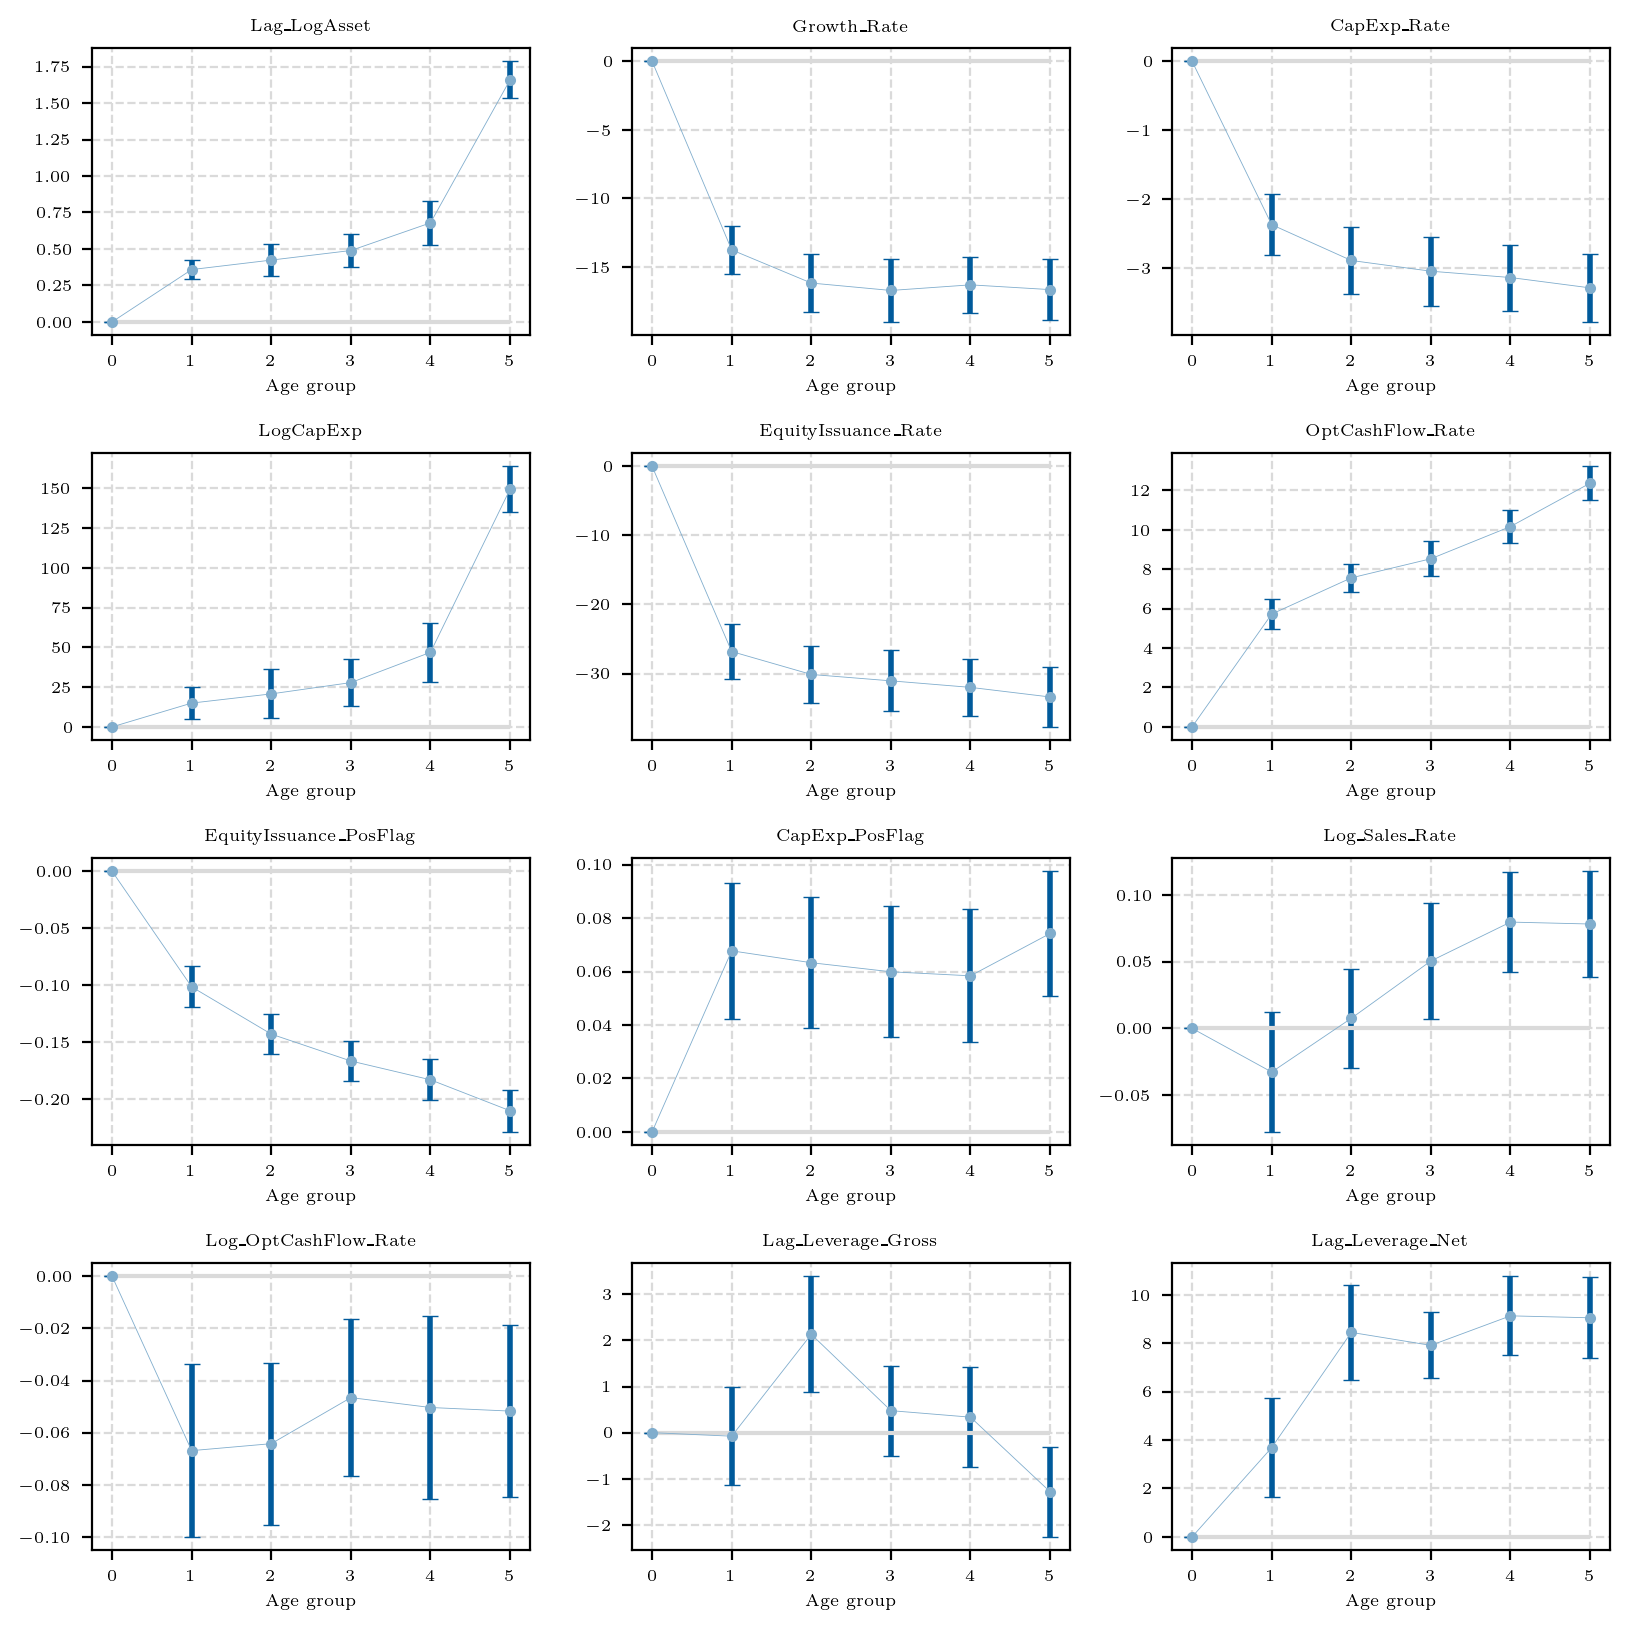

In [101]:
Fig = MyGR.Setup_Fig(FigSize=(1/2 * 2, 1/4 * 4))
for (ii, vv) in enumerate(YVarList):
    ax = Fig.add_subplot(4,3,ii+1)
    TempPlot_LifeCycle(ax, ResultDict[vv], label=vv)

plt.tight_layout()

In [102]:
ResultDict = {}
SampleCondition = "if FirmObs>=1"
XVarList = ['i.age_group2']
for yy in YVarList:
    if yy in ['EquityIssuance_PosFlag', 'CapExp_PosFlag', 'Lag_LogAsset']:
        ResultDict[yy] = UnitReg(yy, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction=SampleCondition, WeightVar='')
    else:
        ResultDict[yy] = UnitReg(yy, XVarList, AbsorbVarList, ClusterVarList, SampleRestriction=SampleCondition, WeightVar='')

Start running regression for Lag_LogAsset :
Done.
Start running regression for Growth_Rate :
Done.
Start running regression for CapExp_Rate :
Done.
Start running regression for LogCapExp :
Done.
Start running regression for EquityIssuance_Rate :
Done.
Start running regression for OptCashFlow_Rate :
Done.
Start running regression for EquityIssuance_PosFlag :
Done.
Start running regression for CapExp_PosFlag :
Done.
Start running regression for Log_Sales_Rate :
Done.
Start running regression for Log_OptCashFlow_Rate :
Done.
Start running regression for Lag_Leverage_Gross :
Done.
Start running regression for Lag_Leverage_Net :
Done.


In [103]:
pd.concat([ResultDict[yy]['Coef'].rename(yy) for yy in YVarList], axis=1)

,Lag_LogAsset,Growth_Rate,CapExp_Rate,LogCapExp,EquityIssuance_Rate,OptCashFlow_Rate,EquityIssuance_PosFlag,CapExp_PosFlag,Log_Sales_Rate,Log_OptCashFlow_Rate,Lag_Leverage_Gross,Lag_Leverage_Net
5bn.age_group2,0.909976,-16.541053,-2.646334,72.681737,-34.012911,12.625722,-0.150929,0.110715,0.047867,-0.023366,-1.492750,3.979146
_cons,4.418183,18.564960,8.445487,120.213604,41.960953,-12.306730,0.298508,0.835852,4.420786,2.180448,29.766268,4.586531


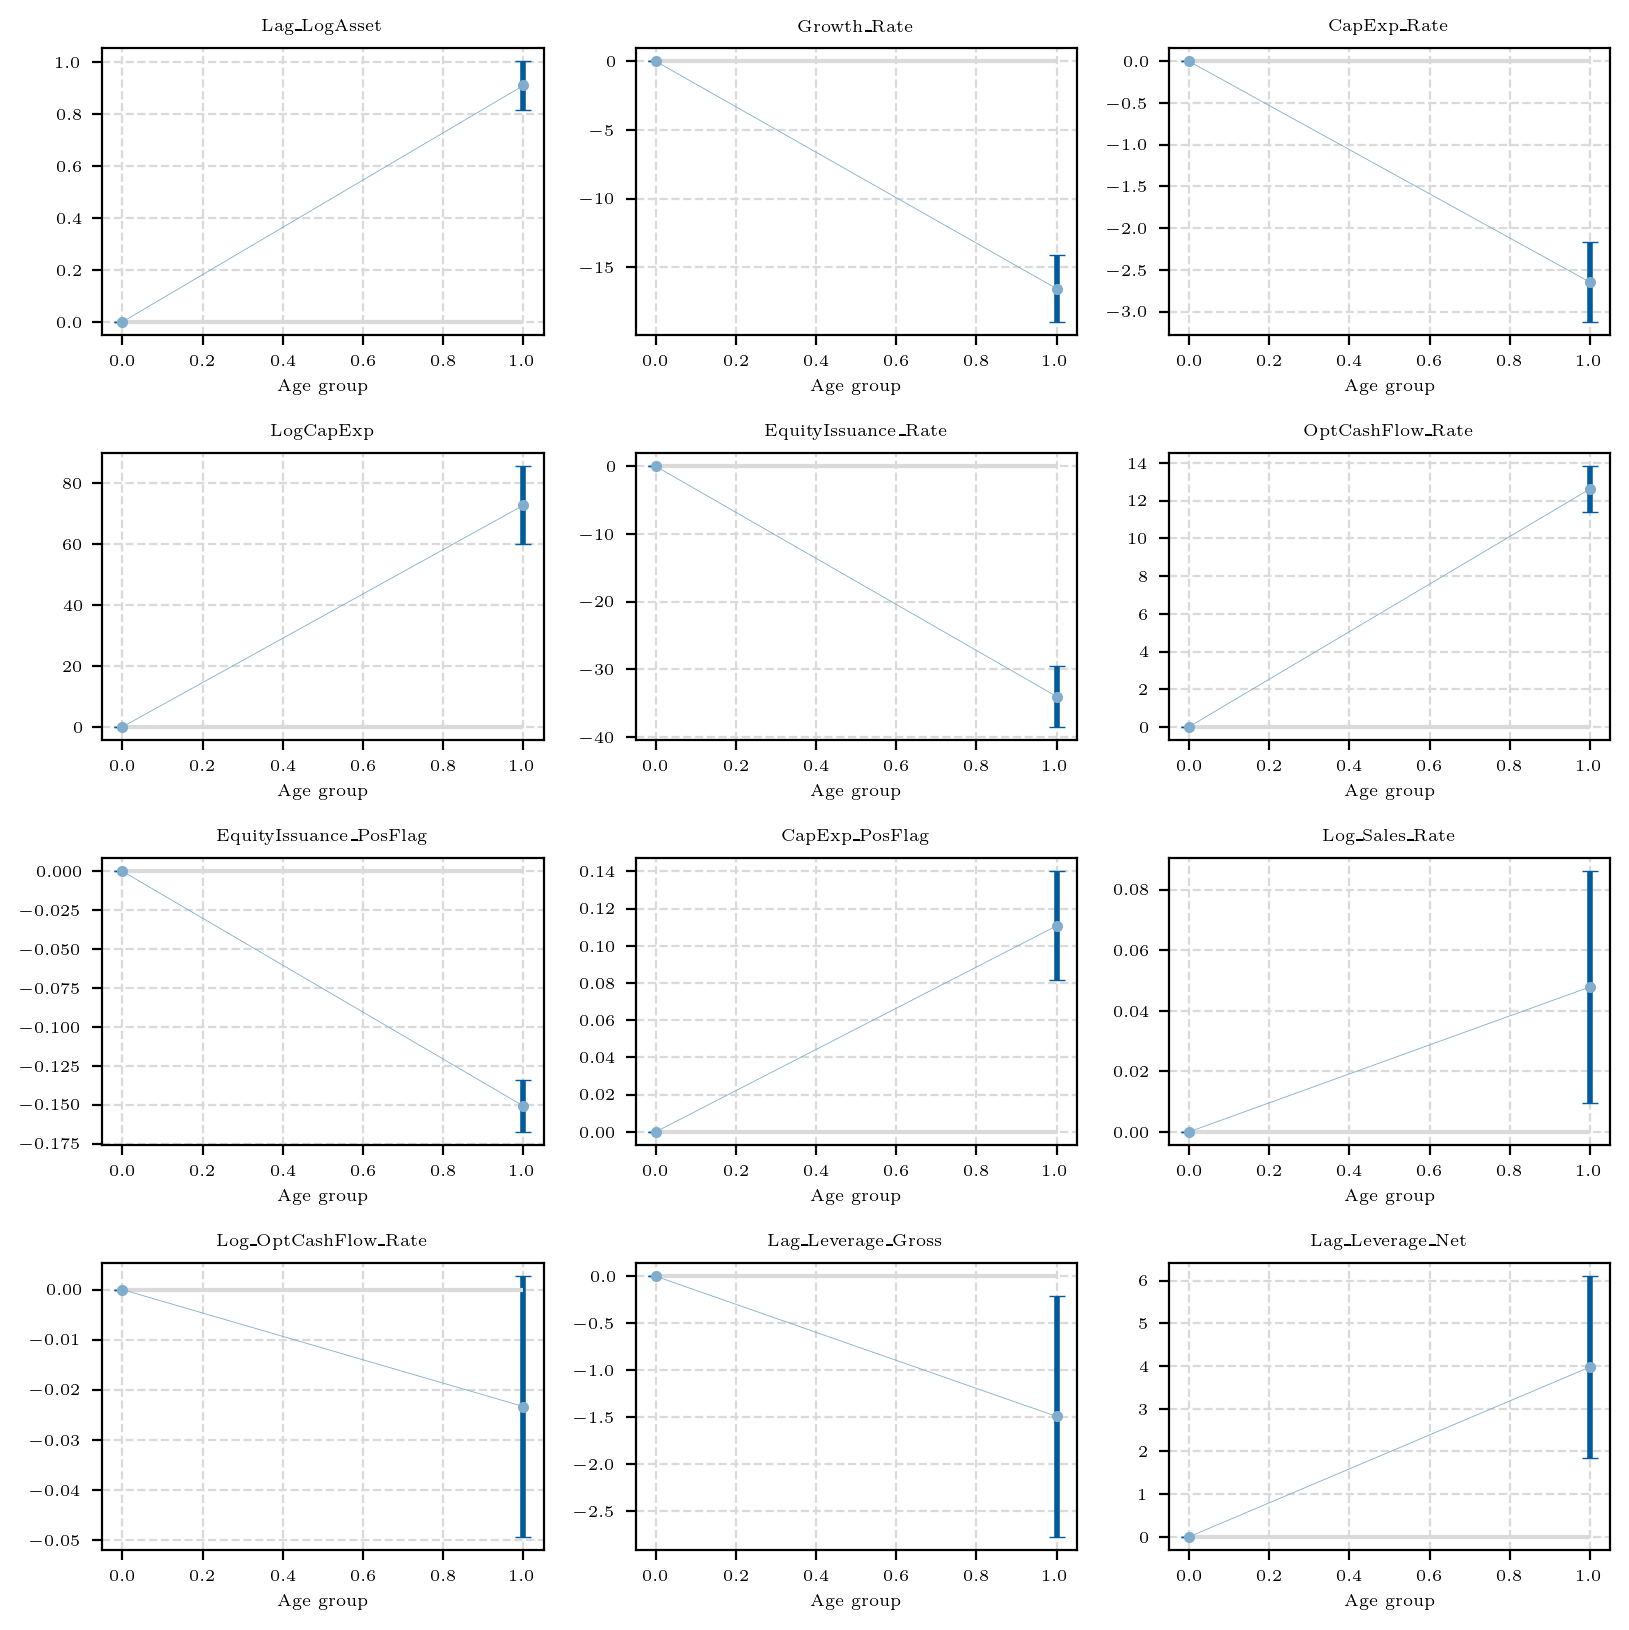

In [104]:
Fig = MyGR.Setup_Fig(FigSize=(1/2 * 2, 1/4 * 4))
for (ii, vv) in enumerate(YVarList):
    ax = Fig.add_subplot(4,3,ii+1)
    TempPlot_LifeCycle(ax, ResultDict[vv], label=vv)

plt.tight_layout()

# Moments based on the filtered variables

## Filter the key variables using regressions with FE

In [170]:
stata.pdataframe_to_data(TempDS.reset_index(),force=True)
stata.run('encode gvkey, gen(gvkey_code)')
stata.run('xtset gvkey_code Year')
stata.run('gen Flag_PosEquIss = (EquityIssuance_Rate>1e-4)*1')


Panel variable: gvkey_code (unbalanced)
 Time variable: Year, 1990 to 2022, but with gaps
         Delta: 1 unit


In [171]:
def UnitRegFilter(YVar, XVarList, AbsorbVarList, SampleRestriction, WeightVar='', RegCommand='reghdfe', Level=90):
    # Compose the Stata Command
    OptionList = []
    OptionList.append('noabsorb') if len(AbsorbVarList)==0 else OptionList.append('absorb('+' '.join(AbsorbVarList)+')')
    OptionList.append('res(Res_'+str(YVar)+')')
    # Run regression
    print('Start running regression for',YVar,':')
    StataCommand = ' '.join([RegCommand,YVar]+XVarList+[SampleRestriction])+('' if len(WeightVar)==0 else ' [weight='+WeightVar+']')+', '+' '.join(OptionList)
    stata.run(StataCommand, quietly=True)

    print('Done.')

    return 

In [172]:
# stata.run('drop Res_*')


In [173]:
AbsorbVarList = ['i.sic#i.Year']
XVarList = []
YVarList = ['Lag_LogAsset', 'CapExp_Rate', 'LogCapExp', 'EquityIssuance_Rate', 'OptCashFlow_Rate', 'EquityIssuance_PosFlag', 'CapExp_PosFlag', 'Log_Sales_Rate', 'Log_OptCashFlow_Rate', 'Lag_Leverage_Gross', 'Lag_Leverage_Net']

In [174]:
ResultDict = {}
SampleCondition = "if FirmObs>=10"

for yy in YVarList:
    UnitRegFilter(yy, XVarList, AbsorbVarList, SampleRestriction=SampleCondition, WeightVar='')

Start running regression for Lag_LogAsset :
Done.
Start running regression for CapExp_Rate :
Done.
Start running regression for LogCapExp :
Done.
Start running regression for EquityIssuance_Rate :
Done.
Start running regression for OptCashFlow_Rate :
Done.
Start running regression for EquityIssuance_PosFlag :
Done.
Start running regression for CapExp_PosFlag :
Done.
Start running regression for Log_Sales_Rate :
Done.
Start running regression for Log_OptCashFlow_Rate :
Done.
Start running regression for Lag_Leverage_Gross :
Done.
Start running regression for Lag_Leverage_Net :
Done.


In [175]:
RegResDS = stata.pdataframe_from_data()

In [176]:
RegResDS

,gvkey,CalendarQtr_Year,CapExp,EquityIssuance,Payout,OptCashFlow,Sales,Asset,NetDebt,Debt,...,Res_CapExp_Rate,Res_LogCapExp,Res_EquityIssuance_Rate,Res_OptCashFlow_Rate,Res_EquityIssuance_PosFlag,Res_CapExp_PosFlag,Res_Log_Sales_Rate,Res_Log_OptCashFlow_Rate,Res_Lag_Leverage_Gross,Res_Lag_Leverage_Net
0,001003,1990,0.024376,0.0,0.015237,-0.856615,20.534080,10.952498,6.915305,7.351185,...,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307
1,001004,1990,28.302407,0.0,16.394737,47.866236,760.703355,620.594018,163.666363,170.684502,...,2.231873e+00,2.906537e+02,0.000000e+00,-1.720758e+00,0.000000e+00,1.818182e-01,-1.881491e-01,-3.890561e-02,-3.054883e+01,-1.613133e+01
2,001004,1991,12.630574,0.0,12.109057,33.253512,705.035883,614.540026,148.084585,154.049452,...,-2.199256e+00,2.404464e+02,0.000000e+00,2.956043e-01,0.000000e+00,1.666667e-01,-3.668852e-01,-5.613697e-01,3.942410e+00,2.079920e+01
3,001004,1992,18.275223,0.0,13.615296,22.173525,641.670861,615.522218,154.797602,162.318544,...,-1.154597e-01,2.735643e+02,0.000000e+00,5.050760e-01,0.000000e+00,9.090909e-02,-3.110564e-01,-9.024451e-01,3.350841e-01,7.606517e+00
4,001004,1993,7.475797,0.0,11.572550,38.264057,567.299971,613.668483,132.209694,175.282958,...,-2.314501e+00,2.189103e+02,-1.332628e-01,1.887087e+00,-8.333333e-02,8.333333e-02,-3.731144e-01,-4.143800e-01,2.651634e+00,1.822355e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154801,345980,2021,1.739716,0.0,0.000000,-845.652347,1853.907146,1106.410188,-985.679536,21.559045,...,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307
154802,345980,2022,1.690461,0.0,18.759667,-348.944428,472.495037,647.460397,-572.098924,16.206768,...,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307
154803,347007,2022,64.680545,0.0,0.512476,-278.253380,0.196462,293.630988,500.908263,587.763576,...,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307
154804,349530,2022,0.125630,0.0,0.000000,-8.255624,2.415922,84.153645,3.351560,5.675610,...,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307,8.988466e+307


In [177]:
Tol = 1e20
for vv in YVarList:
    RegResDS.loc[np.abs(RegResDS[vv])>Tol, vv] = np.nan
    RegResDS.loc[np.abs(RegResDS['Res_'+vv])>Tol, 'Res_'+vv] = np.nan

In [178]:
RegResDS.set_index(['gvkey', 'CalendarQtr_Year'], inplace=True)

## Investment rate

In [179]:
print(RegResDS.groupby('CalendarQtr_Year')[['CapExp_Rate', 'Res_CapExp_Rate']].describe(percentiles=PctList).mean().unstack(level=0))

       CapExp_Rate  Res_CapExp_Rate
count  4469.151515     3.204788e+03
mean      6.000567     3.877852e-17
std       8.856639     6.843749e+00
min       0.000000    -2.786252e+01
0.1%      0.000000    -2.114716e+01
1%        0.000000    -1.420647e+01
5%        0.148896    -6.956376e+00
25%       1.440267    -2.802809e+00
50%       3.338060    -9.480328e-01
75%       6.875271     1.307815e+00
90%      13.511400     5.398051e+00
95%      20.936420     1.009507e+01
99%      45.176170     2.671785e+01
99.5%    58.756689     3.734895e+01
99.9%    85.808253     6.093797e+01
max     101.469844     7.725362e+01


0    1.000000
1    0.579046
2    0.449524
3    0.395843
4    0.378338
5    0.363818
6    0.349795
7    0.347330
8    0.332319
9    0.334447
Name: AutoCorr, dtype: float64


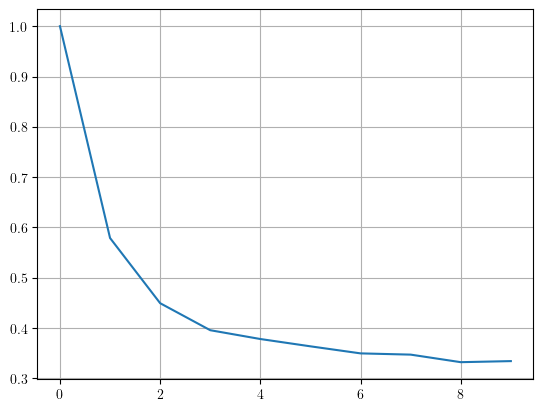

In [180]:
tempVar = 'CapExp_Rate'
temp = RegResDS[tempVar].dropna()
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)

0    1.000000
1    0.283982
2    0.075594
3   -0.015697
4   -0.064818
5   -0.101491
6   -0.124405
7   -0.134552
8   -0.156250
9   -0.149219
Name: AutoCorr, dtype: float64


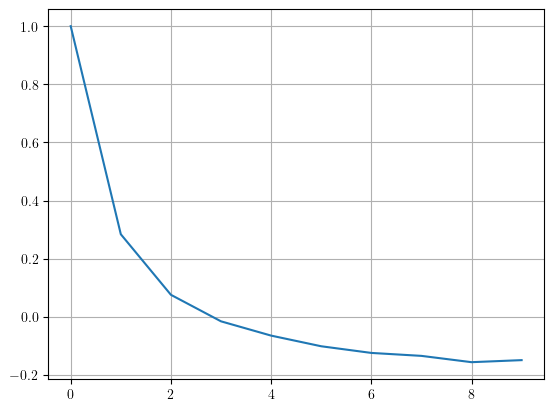

In [156]:
tempVar = 'Res_CapExp_Rate'
temp = RegResDS[tempVar].dropna()
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)

## Log-Investment

In [157]:
print(RegResDS.groupby('CalendarQtr_Year')[['LogCapExp', 'Res_LogCapExp']].describe(percentiles=PctList).mean().unstack(level=0))

         LogCapExp  Res_LogCapExp
count  4334.969697   3.136364e+03
mean    182.698661  -6.321000e-09
std     279.929289   9.902273e+01
min   -1094.931504  -7.440626e+02
0.1%   -774.703045  -5.289992e+02
1%     -519.816432  -3.014815e+02
5%     -307.190249  -1.610543e+02
25%      -3.705814  -4.681473e+01
50%     207.036510   3.409541e+00
75%     380.492656   5.311044e+01
90%     526.684500   1.084523e+02
95%     611.600120   1.496635e+02
99%     750.329185   2.450516e+02
99.5%   783.288201   2.822948e+02
99.9%   818.163112   3.580014e+02
max     828.140566   4.655031e+02


0    1.000000
1    0.924117
2    0.891132
3    0.872057
4    0.859796
5    0.849395
6    0.840635
7    0.834309
8    0.827539
9    0.821175
Name: AutoCorr, dtype: float64


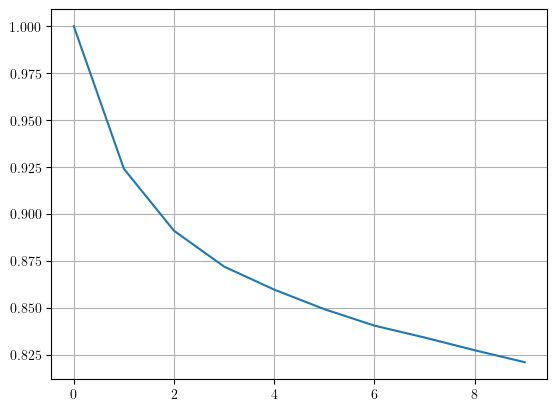

In [158]:
tempVar = 'LogCapExp'
temp = RegResDS[tempVar].dropna()
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)

0    1.000000
1    0.540190
2    0.316923
3    0.170193
4    0.064253
5   -0.024942
6   -0.095355
7   -0.145870
8   -0.185978
9   -0.218322
Name: AutoCorr, dtype: float64


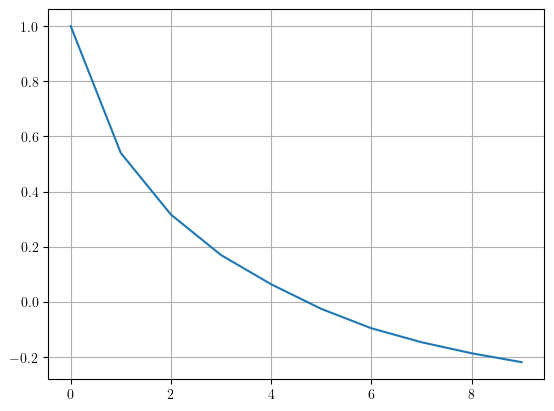

In [119]:
tempVar = 'Res_LogCapExp'
temp = RegResDS[tempVar].dropna()
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)

## Sales rate

In [120]:
print(RegResDS.groupby('CalendarQtr_Year')[['Log_Sales_Rate', 'Res_Log_Sales_Rate']].describe(percentiles=PctList).mean().unstack(level=0))

       Log_Sales_Rate  Res_Log_Sales_Rate
count     4517.939394        3.228273e+03
mean         4.415554        1.162946e-11
std          1.152386        5.857796e-01
min         -4.926444       -5.980499e+00
0.1%        -2.635688       -4.302846e+00
1%           0.018385       -1.997061e+00
5%           2.321914       -7.481735e-01
25%          4.027263       -2.098267e-01
50%          4.611266        3.619944e-03
75%          5.078234        2.254673e-01
90%          5.505912        5.336238e-01
95%          5.778541        8.237981e-01
99%          6.376580        1.632753e+00
99.5%        6.700571        1.951912e+00
99.9%        7.363192        2.725211e+00
max          8.508593        3.957482e+00


0    1.000000
1    0.827112
2    0.739619
3    0.685534
4    0.646257
5    0.616480
6    0.592501
7    0.577071
8    0.561731
9    0.553918
Name: AutoCorr, dtype: float64


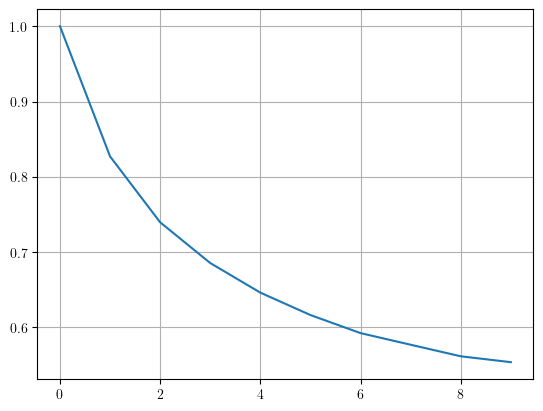

In [121]:
tempVar = 'Log_Sales_Rate'
temp = RegResDS[tempVar].dropna()
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)

0    1.000000
1    0.518903
2    0.273164
3    0.107929
4   -0.015468
5   -0.102313
6   -0.167755
7   -0.208341
8   -0.241899
9   -0.249376
Name: AutoCorr, dtype: float64


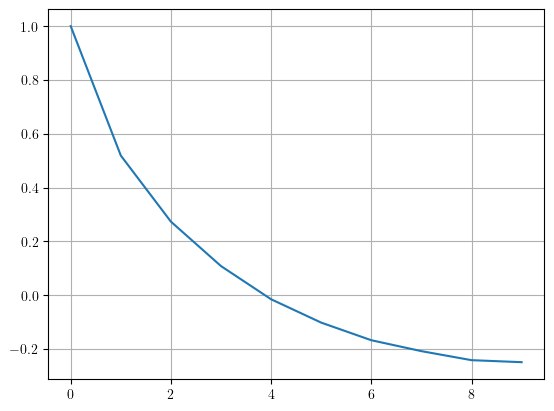

In [122]:
tempVar = 'Res_Log_Sales_Rate'
temp = RegResDS[tempVar].dropna()
AutoCorrDF = pd.Series([Persistence(temp, dt=tt) for tt in range(10)], index=range(10), name='AutoCorr')
plt.plot(AutoCorrDF)
plt.grid('on')

print(AutoCorrDF)